In [1]:
import os
import glob
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import json
import joblib
from tensorflow.keras.models import load_model as keras_load_model
warnings.filterwarnings('ignore')

In [ ]:
# Create directories for saving models and scalers
os.makedirs('saved_models', exist_ok=True)
# os.makedirs('saved_scalers', exist_ok=True)
os.makedirs('model_metadata', exist_ok=True)

In [3]:
# Load data
nasdaq = pd.read_csv('./processed_combined_nasdaq.csv')

In [4]:
def split_into_windows(company_data, window_size, X_data, y_data):
    """
    Splits the company data into time windows for training the model.

    Args:
        company_data: Pandas DataFrame containing the company's stock data.
        window_size: Integer representing the size of the rolling window.
        X_data: List to store the input features (time windows).
        y_data: List to store the target values (stock prices on the next day).
    """
    # Get the 'close' prices from the company data
    prices = company_data['Close'].values

    # Iterate through the data to create time windows and their corresponding target values
    for i in range(len(prices) - window_size - 1):
        # Create a time window of 'window_size' days
        window = prices[i:i + window_size]

        # Append the time window to X_data
        X_data.append(window)

        # Append the price on the day following the window to y_data
        y_data.append(prices[i + window_size + 1])  # Add 1 to predict one day ahead

In [5]:
### Split the data into training, validation and test set
# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.

def train_val_test_split(X_data, y_data, window_size):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # Convert from lists to Numpy arrays for reshaping purpose
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)

    # Reshape the numpy array to fit the neural network input shape requirement
    X_train = X_train.reshape(X_train.shape[0], window_size, 1)
    X_val = X_val.reshape(X_val.shape[0], window_size, 1)
    X_test = X_test.reshape(X_test.shape[0], window_size, 1)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
def normalize(X_train, y_train, X_val, y_val):
    # MinMax normalize the training data
    X_train_norm = X_train.copy()
    y_train_norm = y_train.copy()

    # Handle NaN values in training data
    if np.isnan(X_train).any():
        # Option 1: Fill NaNs with the mean of each column
        X_train = np.nan_to_num(X_train, nan=np.nanmean(X_train))
        y_train = np.nan_to_num(y_train, nan=np.nanmean(y_train))

    for i in range(len(X_train)):
        min_feature = np.min(X_train[i])
        max_feature = np.max(X_train[i])
        X_train_norm[i] = (X_train[i] - min_feature) / (max_feature - min_feature)
        y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

    # MinMax normalize the validation data
    X_val_norm = X_val.copy()
    y_val_norm = y_val.copy()

    # Handle NaN values in validation data
    if np.isnan(X_val).any():
        X_val = np.nan_to_num(X_val, nan=np.nanmean(X_val))
        y_val = np.nan_to_num(y_val, nan=np.nanmean(y_val))

    for i in range(len(X_val)):
        min_feature = np.min(X_val[i])
        max_feature = np.max(X_val[i])
        X_val_norm[i] = (X_val[i] - min_feature) / (max_feature - min_feature)
        y_val_norm[i] = (y_val[i] - min_feature) / (max_feature - min_feature)

    return X_train_norm, y_train_norm, X_val_norm, y_val_norm

In [7]:
# Build the model
def build_model(window_size):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(window_size, 1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=128))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))  # Output 1 prediction at a time (e.g., the close price of the next day)
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

In [8]:
def MinMaxScaling(X_test):
  # MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
  X_test_norm = X_test.copy()
  for i in range(0, len(X_test)):
      min_feature = np.min(X_test[i])
      max_feature = np.max(X_test[i])
      X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)

  return X_test_norm

In [9]:
def features_prediction(company_data, window_size):
    # Select the relevant features: Low, High, Open, Close, Adjusted Close, Volume
    feature_columns = ['open', 'high', 'low', 'volume']

    # Extract the last 'window_size' rows for the selected features
    X_predict_original = company_data[feature_columns].iloc[len(company_data) - window_size: len(company_data)]

    # Convert from DataFrame to Numpy array for reshaping
    X_predict = np.array(X_predict_original)

    # Ensure the correct shape: (samples, window_size, num_features)
    # Here we need to select only one feature for prediction
    # Example: use 'close' as the feature (ensure this exists in your columns)
    # Replace 'close' with the feature you actually want to predict


    close_index = feature_columns.index('high')  # You can replace 'high' with any valuable that you want

    # Reshape to keep only the 'close' feature
    X_predict = X_predict[:, close_index:close_index+1]  # Shape: (window_size, 1)

    # Ensure the shape is (1, window_size, 1)
    X_predict = X_predict.reshape(1, window_size, 1)  # Shape: (1, window_size, 1)

    # Normalize the test data using MinMax normalization
    scaler = MinMaxScaler()
    X_predict_norm = scaler.fit_transform(X_predict.reshape(-1, X_predict.shape[2]))  # Flatten for scaling
    X_predict_norm = X_predict_norm.reshape(X_predict.shape[0], X_predict.shape[1], X_predict.shape[2])  # Reshape back

    return X_predict, X_predict_norm


### kth day

In [10]:
def predict_future_days(company_data, window_size, model, X_predict, X_predict_norm, k):
    # Ensure that the model can predict multiple steps ahead
    predictions = []

    # Loop to predict k days ahead
    for i in range(k):
        # Get prediction
        y_pred_norm = model.predict(X_predict_norm)
        predictions.append(y_pred_norm[0])  # Collect the prediction

        # Prepare the next input based on the current prediction
        # Reshape y_pred_norm to match the number of features in X_predict_norm
        y_pred_reshaped = np.zeros((1, 1, X_predict_norm.shape[2]))  # Create a new array with the same feature size
        y_pred_reshaped[0, 0, :1] = y_pred_norm  # Fill only the first feature with the prediction

        # Concatenate the latest prediction as the new input
        X_predict_norm = np.concatenate((X_predict_norm[:, 1:, :], y_pred_reshaped), axis=1)  # Shift the window

    predictions = np.array(predictions)

    # Check if k is valid (this is to prevent index errors)
    if k > len(predictions):
        raise ValueError("k is larger than the number of predictions available.")

    # Return all predictions made
    return predictions  # Return all predictions for analysis

In [11]:
def save_model_and_metadata(model, company, window_size, mse_score, training_history):
    """
    Save the trained model and its metadata
    
    Args:
        model: Trained Keras model
        company: Company name
        window_size: Window size used for training
        mse_score: MSE score on test set
        training_history: Training history from model.fit()
    """
    # Clean company name for file naming
    clean_company_name = "".join(c for c in company if c.isalnum() or c in (' ', '-', '_')).rstrip()
    clean_company_name = clean_company_name.replace(' ', '_')
    
    # Save the model
    model_filename = f"saved_models/{clean_company_name}_model.h5"
    model.save(model_filename)
    print(f"Model saved: {model_filename}")
    
    # Save model metadata
    metadata = {
        'company': company,
        'window_size': window_size,
        'mse_score': float(mse_score),
        'training_date': datetime.now().isoformat(),
        'model_filename': model_filename,
        'training_history': {
            'loss': [float(x) for x in training_history.history['loss']],
            'val_loss': [float(x) for x in training_history.history['val_loss']] if 'val_loss' in training_history.history else [],
            'mse': [float(x) for x in training_history.history['mse']] if 'mse' in training_history.history else [],
            'val_mse': [float(x) for x in training_history.history['val_mse']] if 'val_mse' in training_history.history else []
        }
    }
    
    metadata_filename = f"model_metadata/{clean_company_name}_metadata.json"
    with open(metadata_filename, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"Metadata saved: {metadata_filename}")
    
    return model_filename, metadata_filename

In [12]:
def load_saved_model(company):
    """
    Load a previously saved model
    
    Args:
        company: Company name
        
    Returns:
        model: Loaded Keras model
        metadata: Model metadata
    """
    # Clean company name for file naming
    clean_company_name = "".join(c for c in company if c.isalnum() or c in (' ', '-', '_')).rstrip()
    clean_company_name = clean_company_name.replace(' ', '_')
    
    model_filename = f"saved_models/{clean_company_name}_model.h5"
    metadata_filename = f"model_metadata/{clean_company_name}_metadata.json"
    
    if not os.path.exists(model_filename) or not os.path.exists(metadata_filename):
        raise FileNotFoundError(f"Model or metadata not found for {company}")
    
    # Load model
    model = keras_load_model(model_filename)
    
    # Load metadata
    with open(metadata_filename, 'r') as f:
        metadata = json.load(f)
    
    print(f"Model loaded: {model_filename}")
    print(f"Metadata loaded: {metadata_filename}")
    
    return model, metadata

In [13]:
def kth_day(company, company_data, window_size, k, save_model=True):
    X_data = []
    y_data = []

    ### Handle NaN values in company_data before processing
    for column in company_data.columns:
        if np.issubdtype(company_data[column].dtype, np.number):
            # Fill NaN values with the mean of the column
            company_data[column] = company_data[column].fillna(company_data[column].mean())
        else:
            # For non-numeric types (e.g., datetime), you can fill NaNs with a specific value or method
            company_data[column] = company_data[column].fillna(method='ffill')

    # Check for any remaining NaN values in the dataset
    if company_data.isnull().any().any():
        print(f"Warning: NaN values still present in {company}. Please check the data.")
        return  # Early exit if NaN values are present

    ### Split the dataset into time windows to get data samples.
    split_into_windows(company_data, window_size, X_data, y_data)

    ### Train-Val-Test Split
    X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_data, y_data, window_size)

    ### Check for NaN values in train/val/test sets
    for dataset, name in zip([X_train, y_train, X_val, y_val, X_test, y_test],
                             ['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test']):
        if np.isnan(dataset).any():
            print(f"Error: NaN values present in {name}.")
            return  # Early exit if NaN values are found

    ### Normalizing training and validation data
    X_train_norm, y_train_norm, X_val_norm, y_val_norm = normalize(X_train, y_train, X_val, y_val)
    print("X_train_norm shape: ", X_train_norm.shape)
    print("y_train_norm shape: ", y_train_norm.shape)

    ### Create and train the model
    model = build_model(window_size)

    # Compile and train the model with Mean Squared Error loss function
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
    history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm, y_val_norm), epochs=10, batch_size=1024)

    ### Normalizing test data
    X_test_norm = MinMaxScaling(X_test)
    y_test_norm = y_test.copy()
    for i in range(len(X_test)):
        min_feature = np.min(X_test[i])
        max_feature = np.max(X_test[i])
        y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

    ### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
    y_pred_norm = model.predict(X_test_norm)
    mse_score = mean_squared_error(y_pred_norm, y_test_norm)
    print("MSE on the test set: ", mse_score)

    # Save the model and metadata
    if save_model:
        try:
            model_filename, metadata_filename = save_model_and_metadata(model, company, window_size, mse_score, history)
        except Exception as e:
            print(f"Error saving model for {company}: {e}")

    # Convert the result back to stock price (i.e., de-normalization) for visualization purpose
    y_pred_denorm = np.zeros_like(y_pred_norm)
    for i in range(len(y_pred_denorm)):
        min_feature = np.min(X_test[i])
        max_feature = np.max(X_test[i])
        y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

    ### Prediction for k-th day
    kth_day_stock_price = None  # Initialize kth_day_stock_price to None
    X_predict = None
    X_predict_norm = None
    try:
        X_predict, X_predict_norm = features_prediction(company_data, window_size)
    except Exception as e:
        print(f"Error generating features for prediction: {e}")

    if X_predict is not None and X_predict_norm is not None:
        kth_day_stock_price = predict_future_days(company_data, window_size, model, X_predict, X_predict_norm, k)
        print("Prediction done")

        if np.ndim(kth_day_stock_price) > 0:
            kth_day_stock_price = kth_day_stock_price[0]
    else:
        print("Failed to generate prediction features.")
        
    # Check if kth_day_stock_price has been assigned a value
    if kth_day_stock_price is not None:
        plt.scatter(len(y_pred_denorm) + k - 1, kth_day_stock_price, color='red', label='Predicted kth Day Price')
    else:
        print("Warning: kth_day_stock_price is None, skipping scatter plot.")

    # Clear previous figures
    plt.clf()
    plt.close()

    # Visualize predicted stock price versus real stock price
    plt.figure(figsize=(16, 8), dpi=300)

    # Define x-axis ranges
    days_range = np.arange(len(y_pred_denorm))  # x-axis for predicted prices
    real_days_range = np.arange(len(y_test))  # x-axis for real prices

    # Plot predicted prices
    plt.plot(days_range, y_pred_denorm, label='Predicted price', color='royalblue')

    # Plot real prices (up to the length of predictions)
    plt.plot(real_days_range[:len(y_pred_denorm)], y_test[:len(y_pred_denorm)], label='Real price', color='seagreen')

    # Add vertical line for the k-th day prediction
    plt.axvline(x=len(y_pred_denorm) - 1 + k, color='red', linestyle='--', label=f'Predicted price on day {k}')

    # Add scatter plot for the k-th day prediction
    if kth_day_stock_price is not None and np.isfinite(kth_day_stock_price):
        plt.scatter(len(y_pred_denorm) + k - 1, kth_day_stock_price, color='red', label='Predicted kth Day Price')

    # Add title and labels
    plt.title(f'Stock price prediction for the {k}-th day ahead - {company}', fontsize=16)
    plt.xlabel('Time (days)', fontsize=14)
    plt.ylabel('Close price in $', fontsize=14)
    plt.grid()
    plt.legend()
    plt.show()

In [14]:
def list_saved_models():
    """
    List all saved models and their metadata
    """
    model_files = glob.glob("saved_models/*.h5")
    if not model_files:
        print("No saved models found.")
        return
    
    print("Saved models:")
    for model_file in model_files:
        company_name = os.path.basename(model_file).replace('_model.h5', '').replace('_', ' ')
        metadata_file = f"model_metadata/{os.path.basename(model_file).replace('_model.h5', '_metadata.json')}"
        
        if os.path.exists(metadata_file):
            with open(metadata_file, 'r') as f:
                metadata = json.load(f)
            print(f"  - {metadata['company']} (MSE: {metadata['mse_score']:.6f}, Trained: {metadata['training_date'][:10]})")
        else:
            print(f"  - {company_name} (No metadata available)")

Processing data for AAPL.
Processing data for ADBE.
Processing data for AMZN.
Processing data for ASML.
Processing data for CSCO.
Processing data for INTC.
Processing data for MSFT.
Processing data for NFLX.
Processing data for NVDA.
Processing data for ORLY.
X_train_norm shape:  (6700, 120, 1)
y_train_norm shape:  (6700,)


2025-06-22 00:35:40.199426: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-06-22 00:35:40.199464: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-06-22 00:35:40.199467: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-06-22 00:35:40.199638: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-22 00:35:40.199648: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2025-06-22 00:35:40.931448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 507ms/step - loss: 3.0294 - mse: 3.0294 - val_loss: 0.1274 - val_mse: 0.1274
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - loss: 0.1045 - mse: 0.1045 - val_loss: 0.0575 - val_mse: 0.0575
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 372ms/step - loss: 0.0664 - mse: 0.0664 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 381ms/step - loss: 0.0387 - mse: 0.0387 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 363ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/step - loss: 0.0249 - mse: 0.0249 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0177 - val_mse: 0.0177
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - loss: 0.0228 - mse: 0.0228 - va

MSE on the test set:  0.01696283507933757
Model saved: saved_models/AAPL_model.h5
Metadata saved: model_metadata/AAPL_metadata.json
Error generating features for prediction: "None of [Index(['open', 'high', 'low', 'volume'], dtype='object')] are in the [columns]"
Failed to generate prediction features.


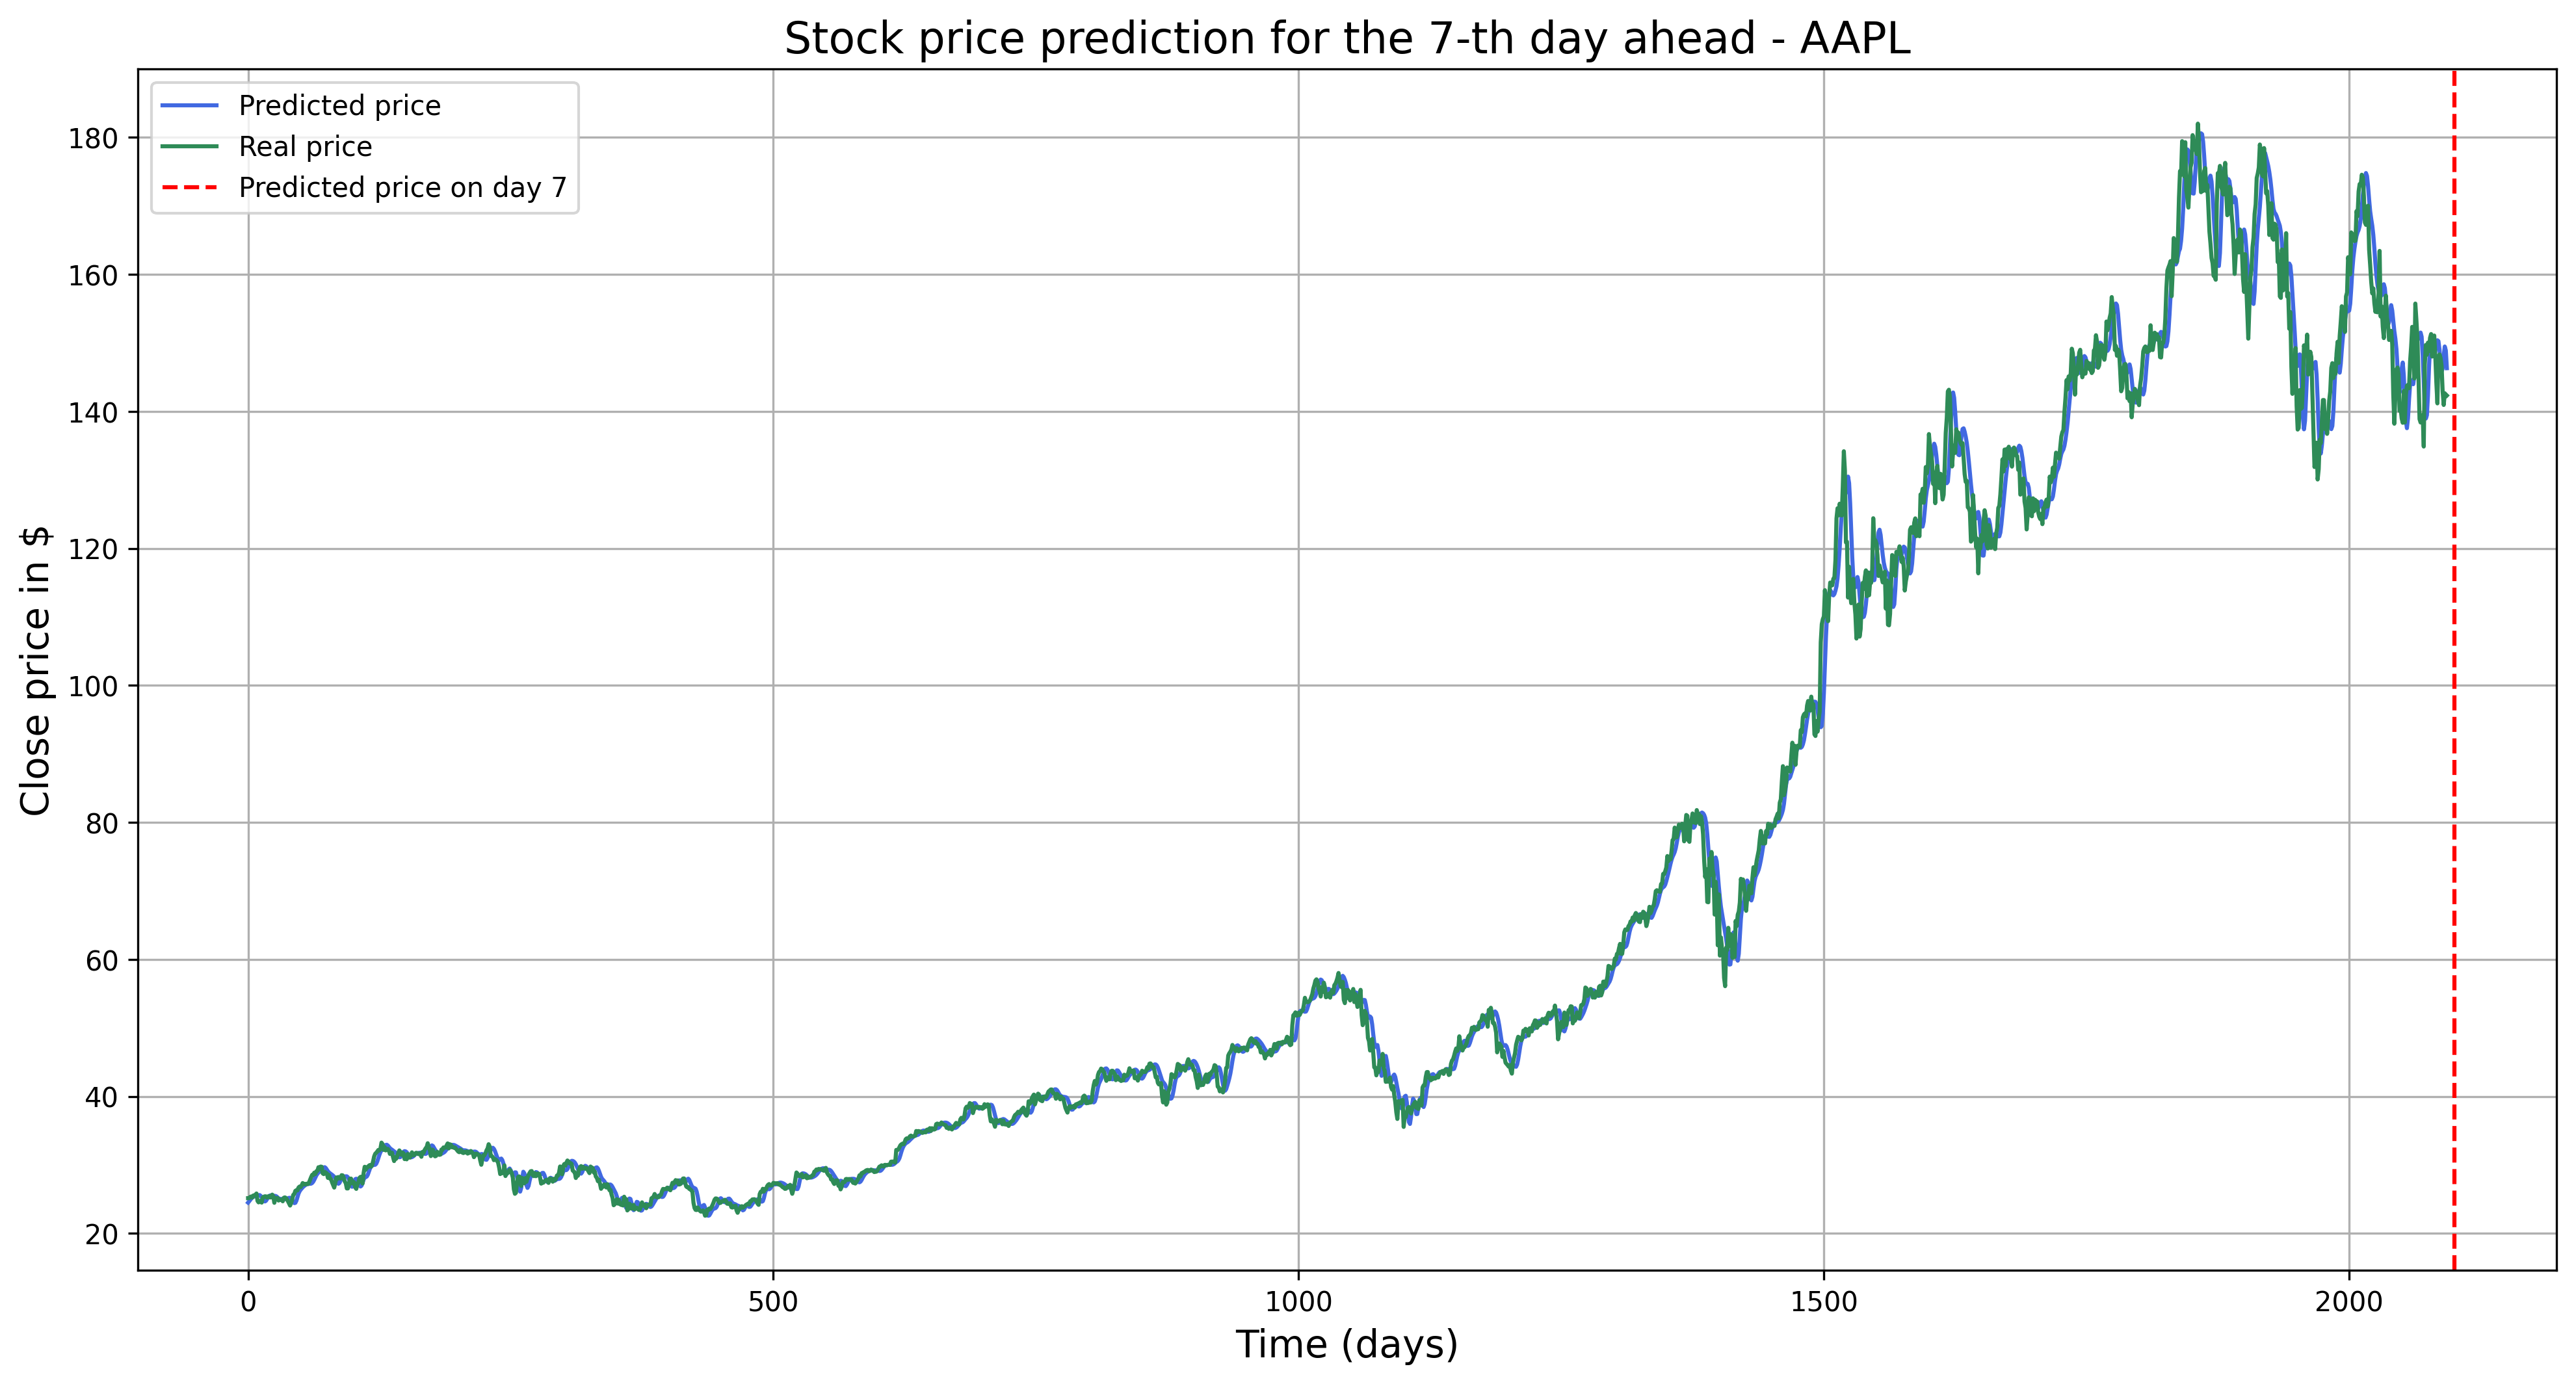

X_train_norm shape:  (5783, 120, 1)
y_train_norm shape:  (5783,)
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 452ms/step - loss: 1.4258 - mse: 1.4258 - val_loss: 0.3707 - val_mse: 0.3707
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step - loss: 0.2581 - mse: 0.2581 - val_loss: 0.1281 - val_mse: 0.1281
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - loss: 0.0972 - mse: 0.0972 - val_loss: 0.0604 - val_mse: 0.0604
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step - loss: 0.0712 - mse: 0.0712 - val_loss: 0.0498 - val_mse: 0.0498
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - loss: 0.0531 - mse: 0.0531 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step - loss: 0.0379 - mse: 0.0379 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 363ms/step - loss: 0.0336 - mse: 0.0336 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 430ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0253 - val_mse: 0.0253
Epoch 9

MSE on the test set:  0.021658608196593467
Model saved: saved_models/ADBE_model.h5
Metadata saved: model_metadata/ADBE_metadata.json
Error generating features for prediction: "None of [Index(['open', 'high', 'low', 'volume'], dtype='object')] are in the [columns]"
Failed to generate prediction features.


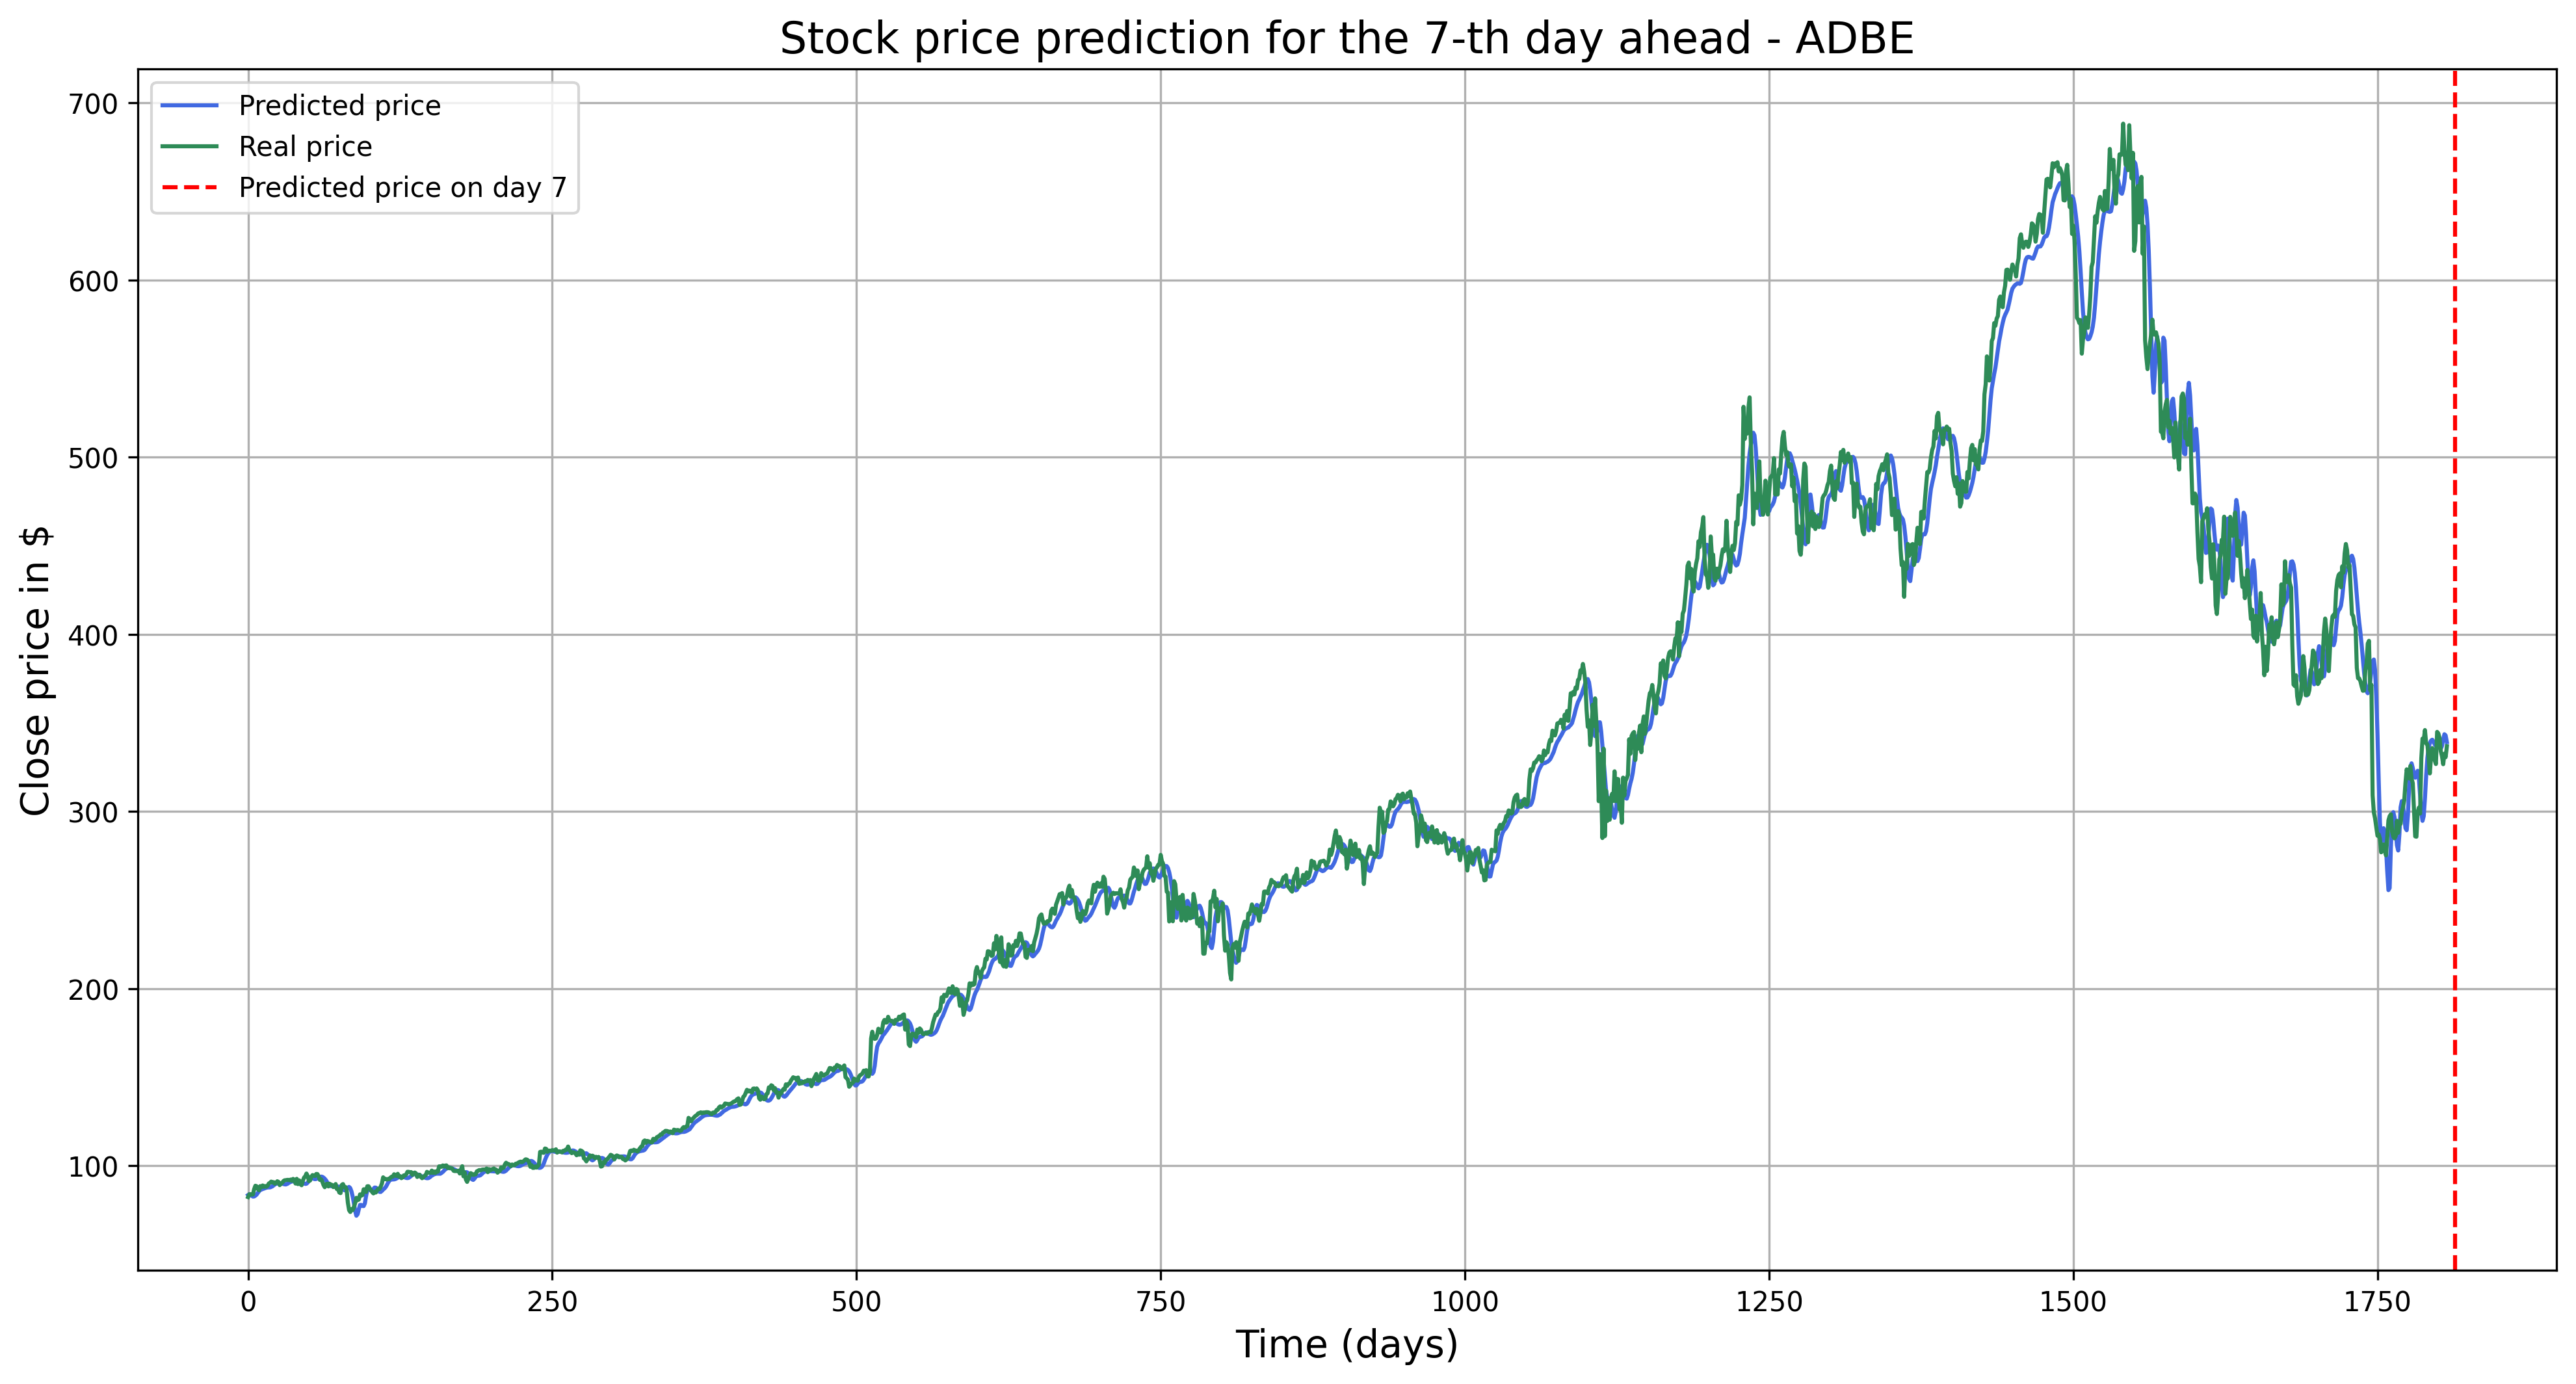

X_train_norm shape:  (4042, 120, 1)
y_train_norm shape:  (4042,)
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 801ms/step - loss: 6.9369 - mse: 6.9369 - val_loss: 0.2223 - val_mse: 0.2223
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 573ms/step - loss: 0.1273 - mse: 0.1273 - val_loss: 0.0692 - val_mse: 0.0692
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 985ms/step - loss: 0.0875 - mse: 0.0875 - val_loss: 0.0449 - val_mse: 0.0449
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 869ms/step - loss: 0.0718 - mse: 0.0718 - val_loss: 0.0769 - val_mse: 0.0769
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 701ms/step - loss: 0.0593 - mse: 0.0593 - val_loss: 0.0358 - val_mse: 0.0358
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 768ms/step - loss: 0.0473 - mse: 0.0473 - val_loss: 0.0242 - val_mse: 0.0242
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 846ms/step - loss: 0.0374 - mse: 0.0374 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0242 - val_mse: 0.0242
Epoch 9/10

MSE on the test set:  0.024154285658075793
Model saved: saved_models/AMZN_model.h5
Metadata saved: model_metadata/AMZN_metadata.json
Error generating features for prediction: "None of [Index(['open', 'high', 'low', 'volume'], dtype='object')] are in the [columns]"
Failed to generate prediction features.


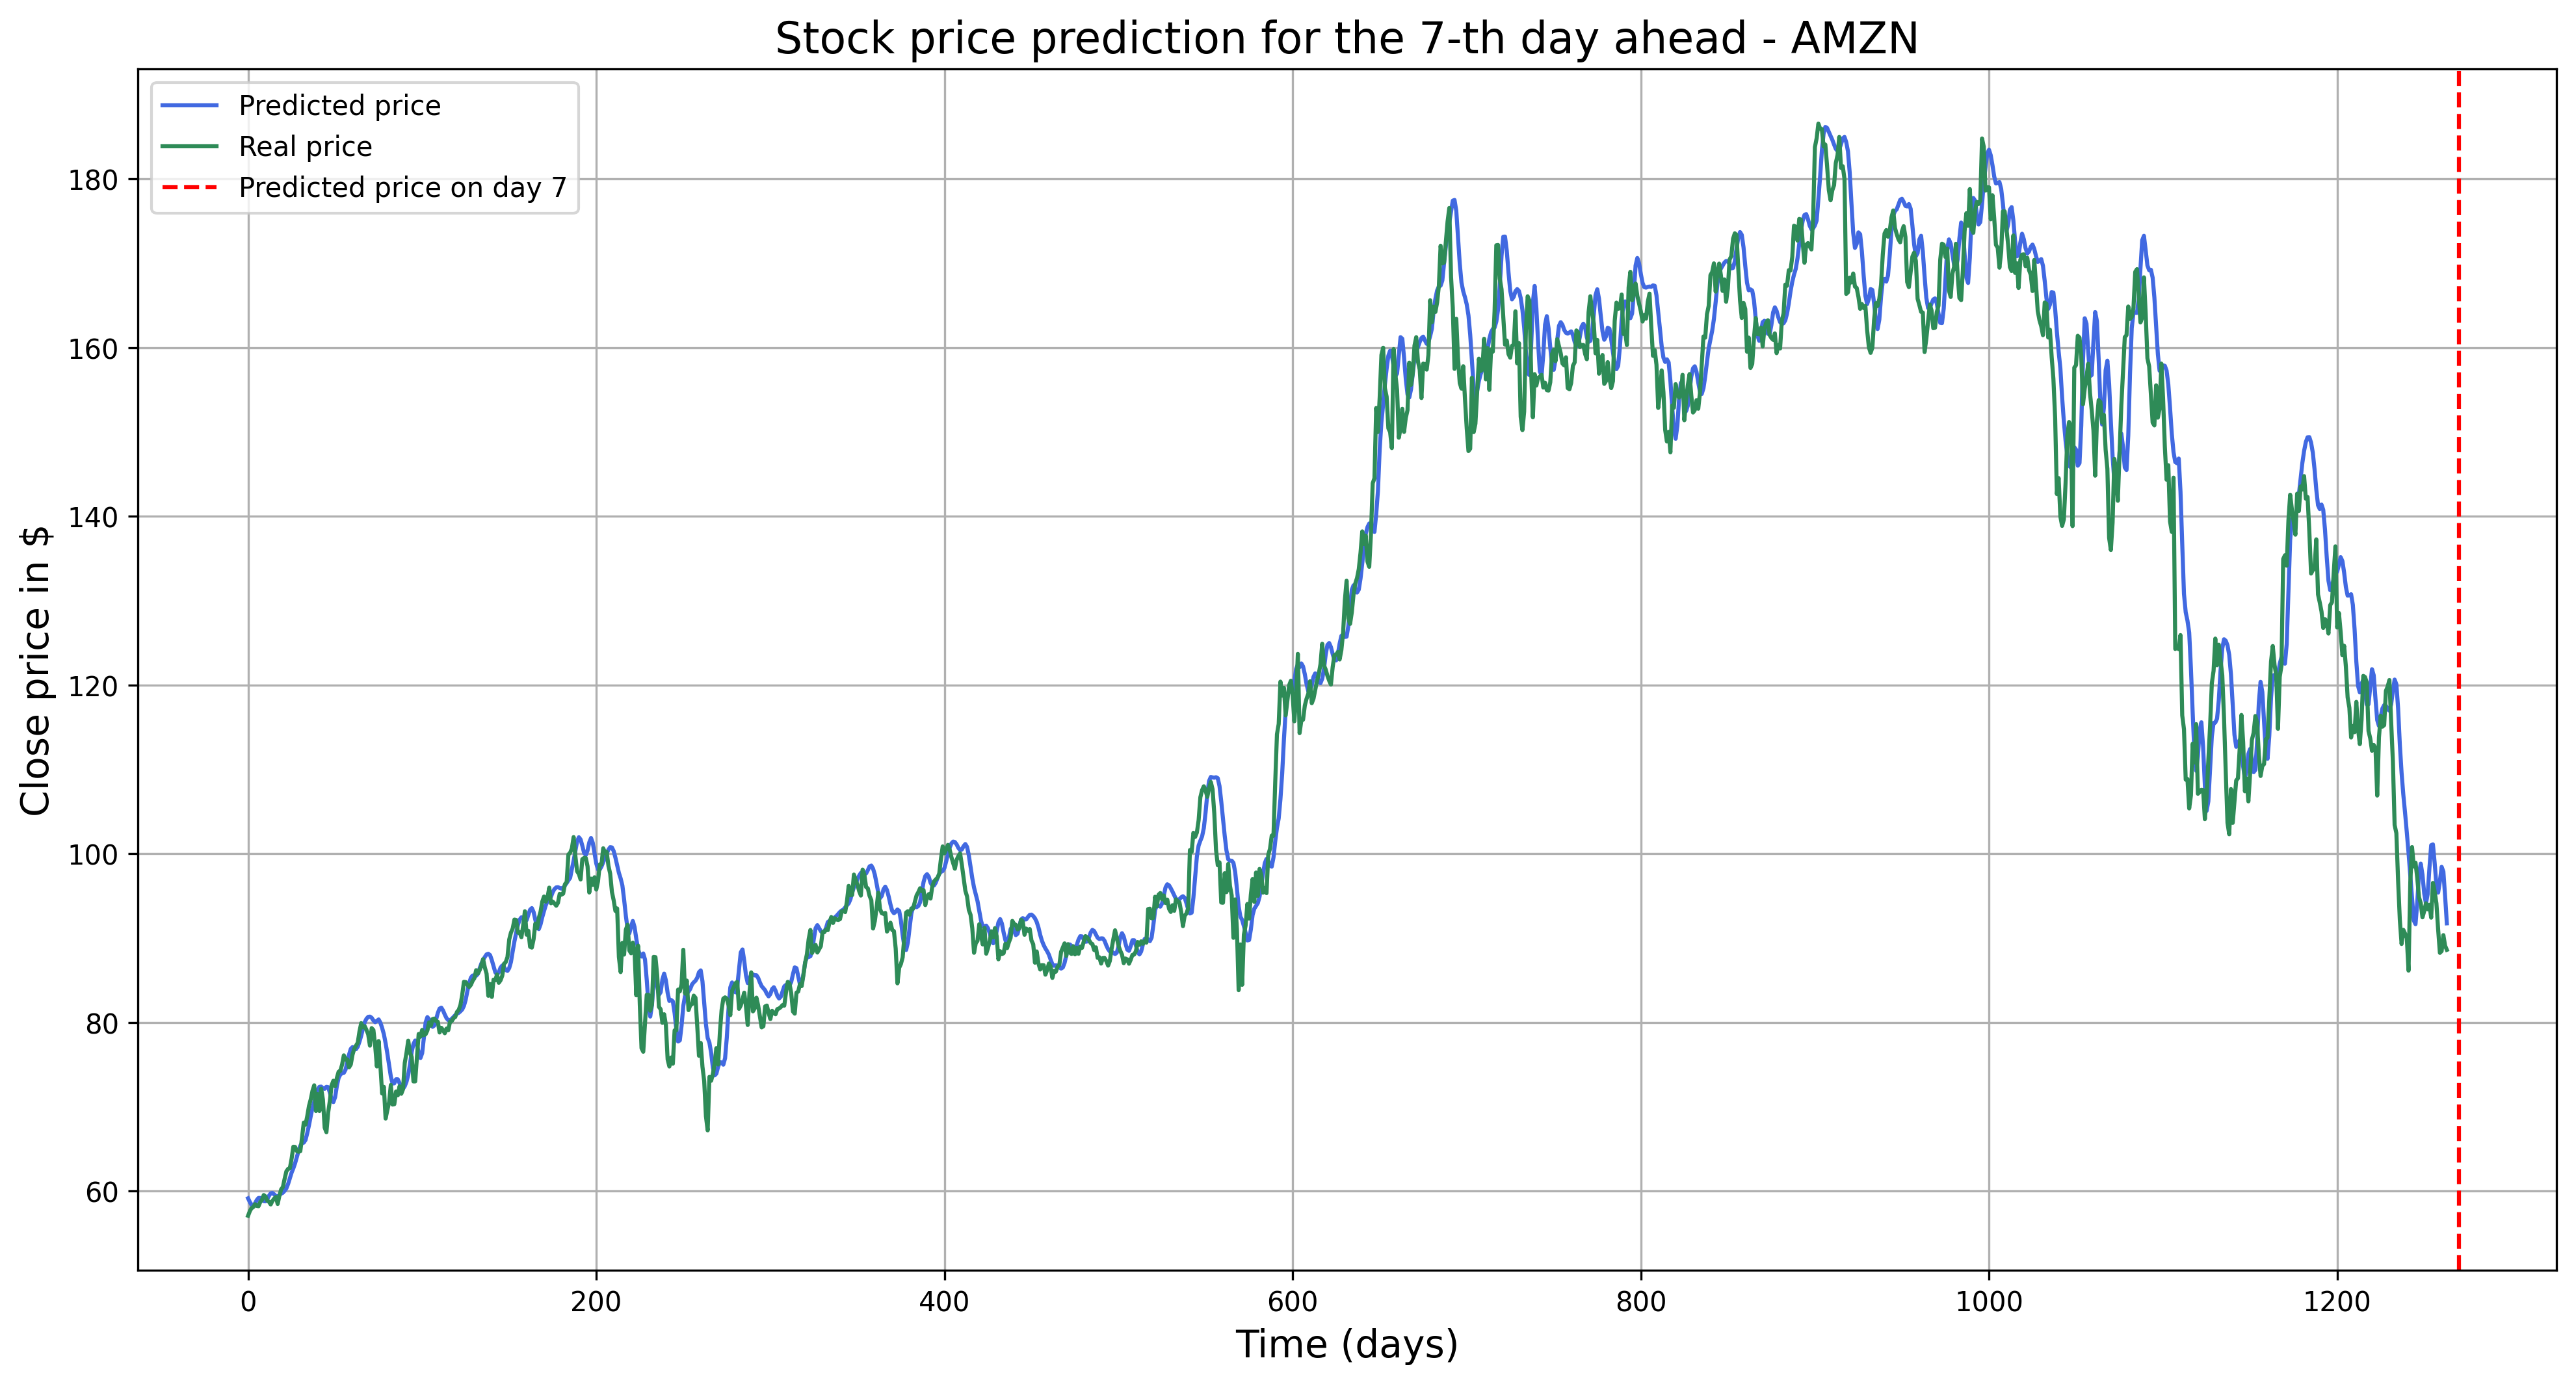

X_train_norm shape:  (4393, 120, 1)
y_train_norm shape:  (4393,)
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 534ms/step - loss: 0.7558 - mse: 0.7558 - val_loss: 0.2133 - val_mse: 0.2133
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - loss: 0.2773 - mse: 0.2773 - val_loss: 0.0835 - val_mse: 0.0835
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - loss: 0.0879 - mse: 0.0879 - val_loss: 0.0724 - val_mse: 0.0724
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - loss: 0.0766 - mse: 0.0766 - val_loss: 0.0465 - val_mse: 0.0465
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - loss: 0.0542 - mse: 0.0542 - val_loss: 0.0417 - val_mse: 0.0417
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - loss: 0.0373 - mse: 0.0373 - val_loss: 0.0383 - val_mse: 0.0383
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0318 - val_mse: 0.0318
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - loss: 0.0269 - mse: 0.0269 - val_loss: 0.0297 - val_mse: 0.0297
Epoch 9

MSE on the test set:  0.024298948026578136
Model saved: saved_models/ASML_model.h5
Metadata saved: model_metadata/ASML_metadata.json
Error generating features for prediction: "None of [Index(['open', 'high', 'low', 'volume'], dtype='object')] are in the [columns]"
Failed to generate prediction features.


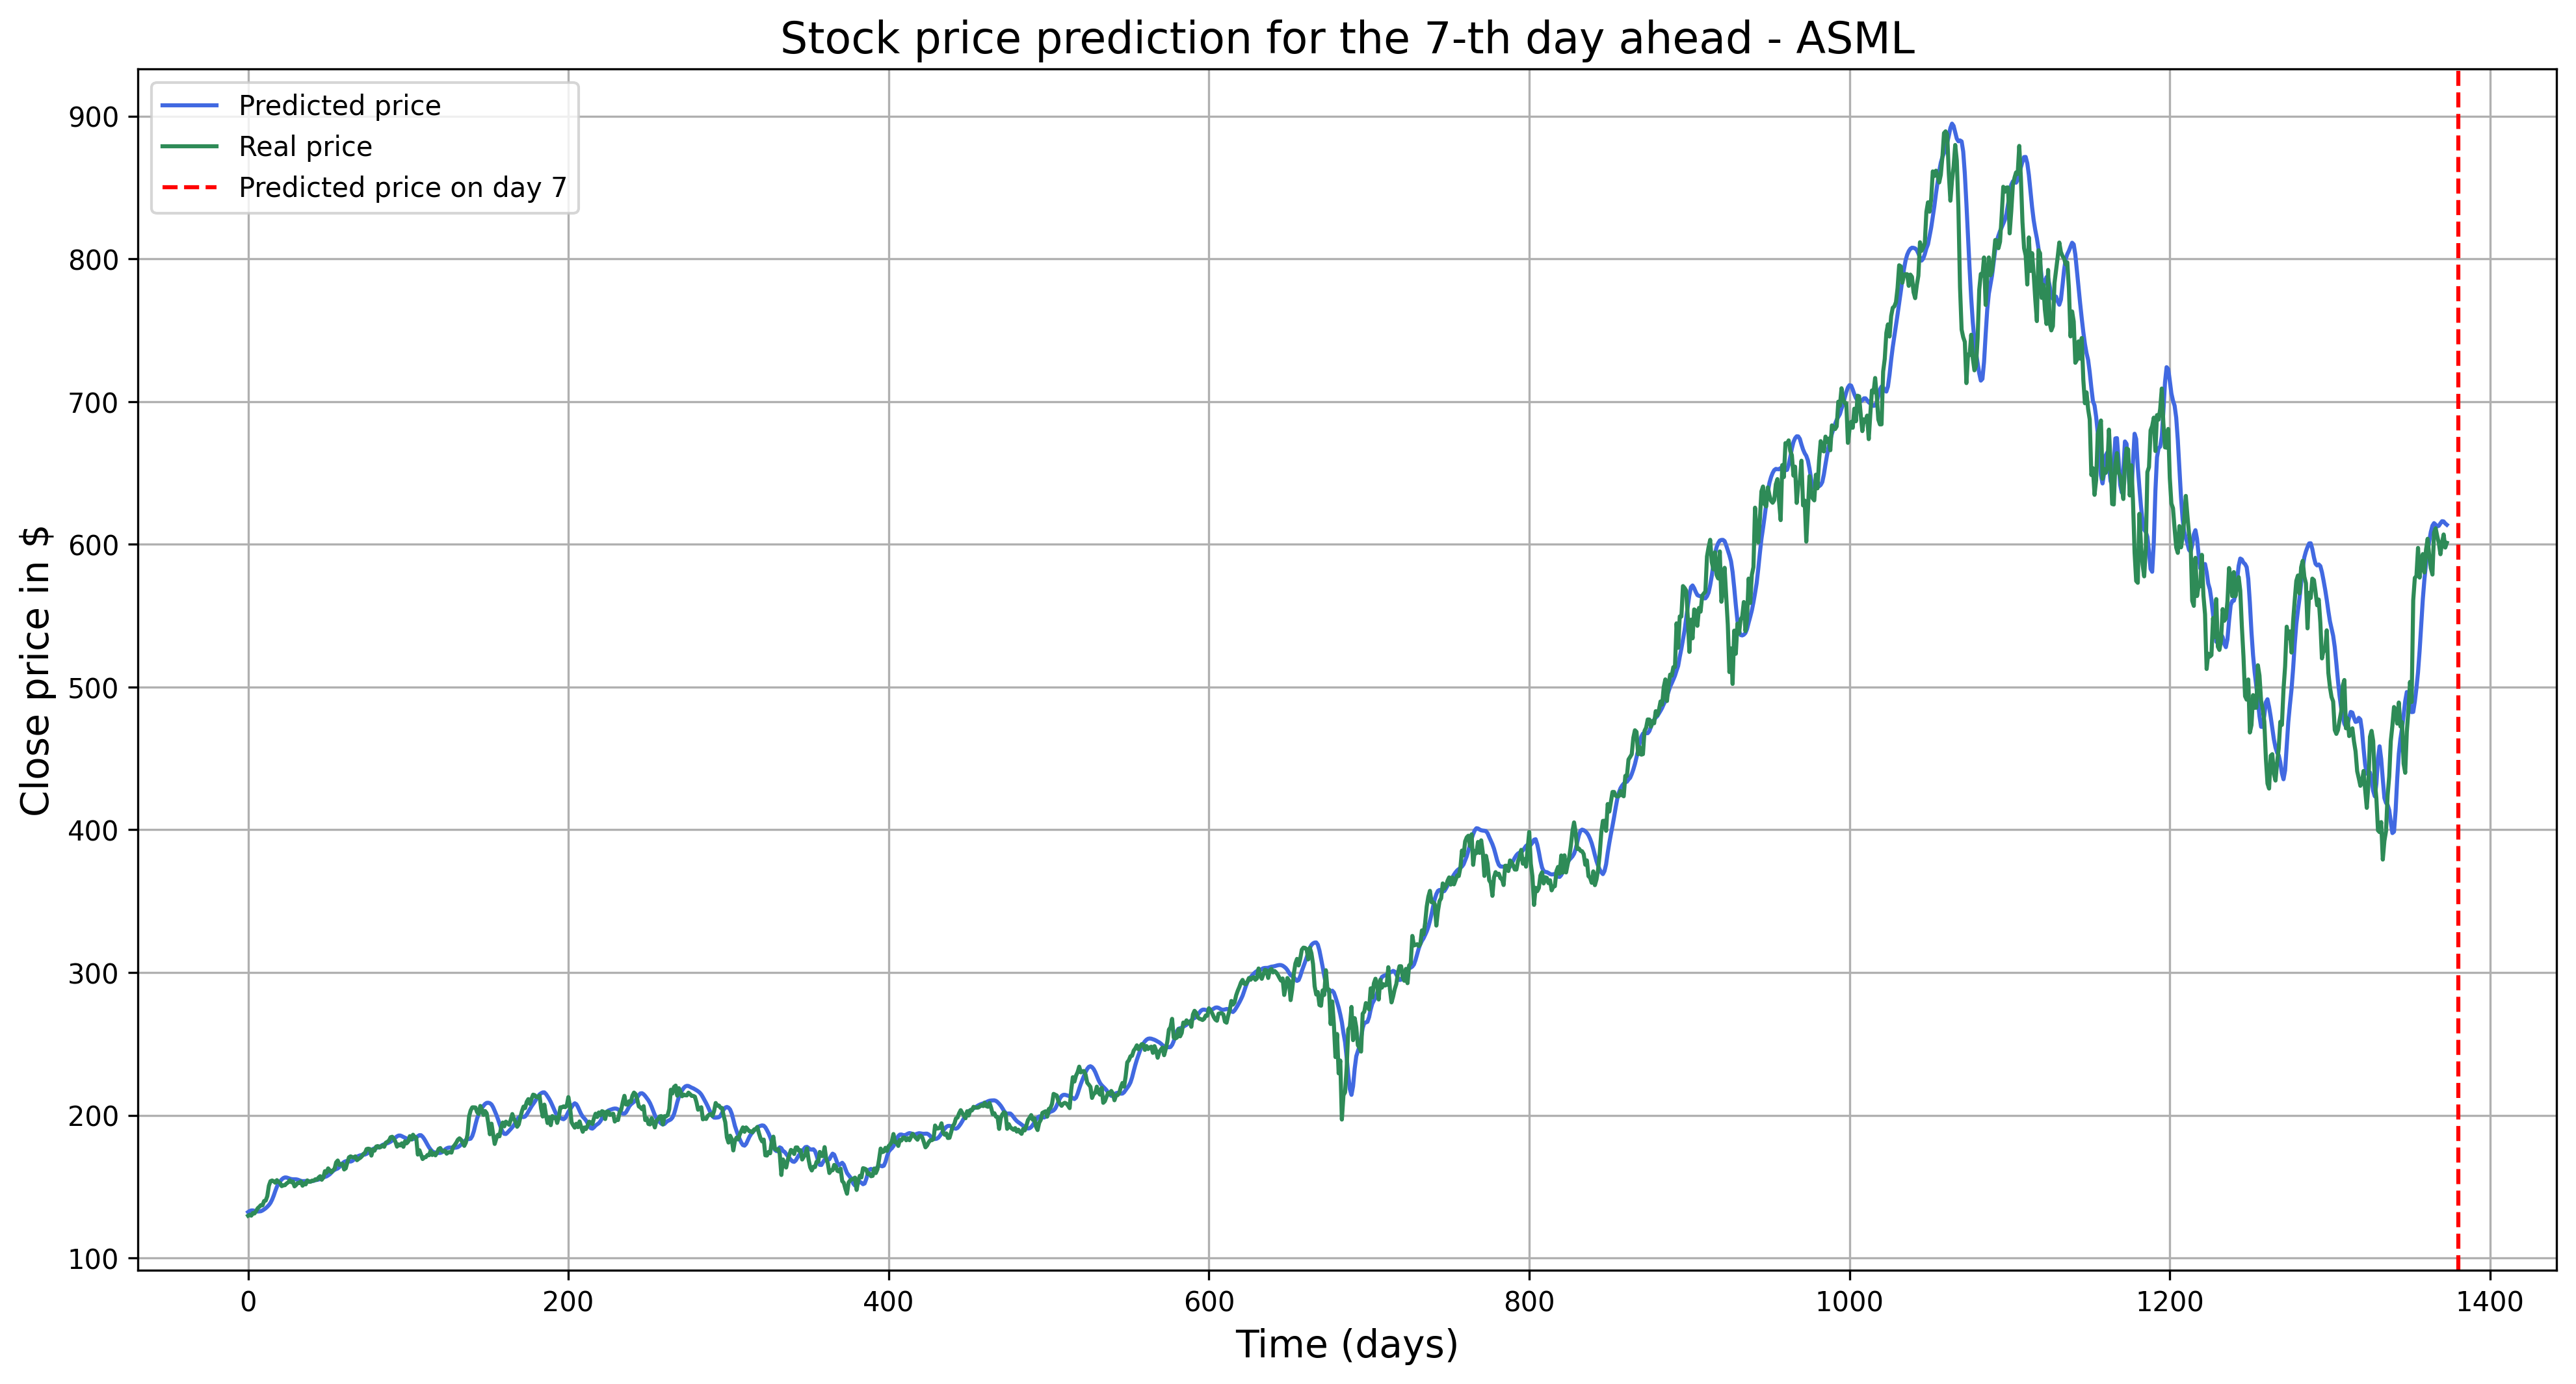

X_train_norm shape:  (5214, 120, 1)
y_train_norm shape:  (5214,)
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/step - loss: 2.1056 - mse: 2.1056 - val_loss: 0.0655 - val_mse: 0.0655
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - loss: 0.0786 - mse: 0.0786 - val_loss: 0.0410 - val_mse: 0.0410
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step - loss: 0.0566 - mse: 0.0566 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - loss: 0.0387 - mse: 0.0387 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step - loss: 0.0328 - mse: 0.0328 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0243 - val_mse: 0.0243
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step - loss: 0.0282 - mse: 0.0282 - val_loss: 0.0237 - val_mse: 0.0237
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - loss: 0.0258 - mse: 0.0258 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 9

MSE on the test set:  0.02041182165139227
Model saved: saved_models/CSCO_model.h5
Metadata saved: model_metadata/CSCO_metadata.json
Error generating features for prediction: "None of [Index(['open', 'high', 'low', 'volume'], dtype='object')] are in the [columns]"
Failed to generate prediction features.


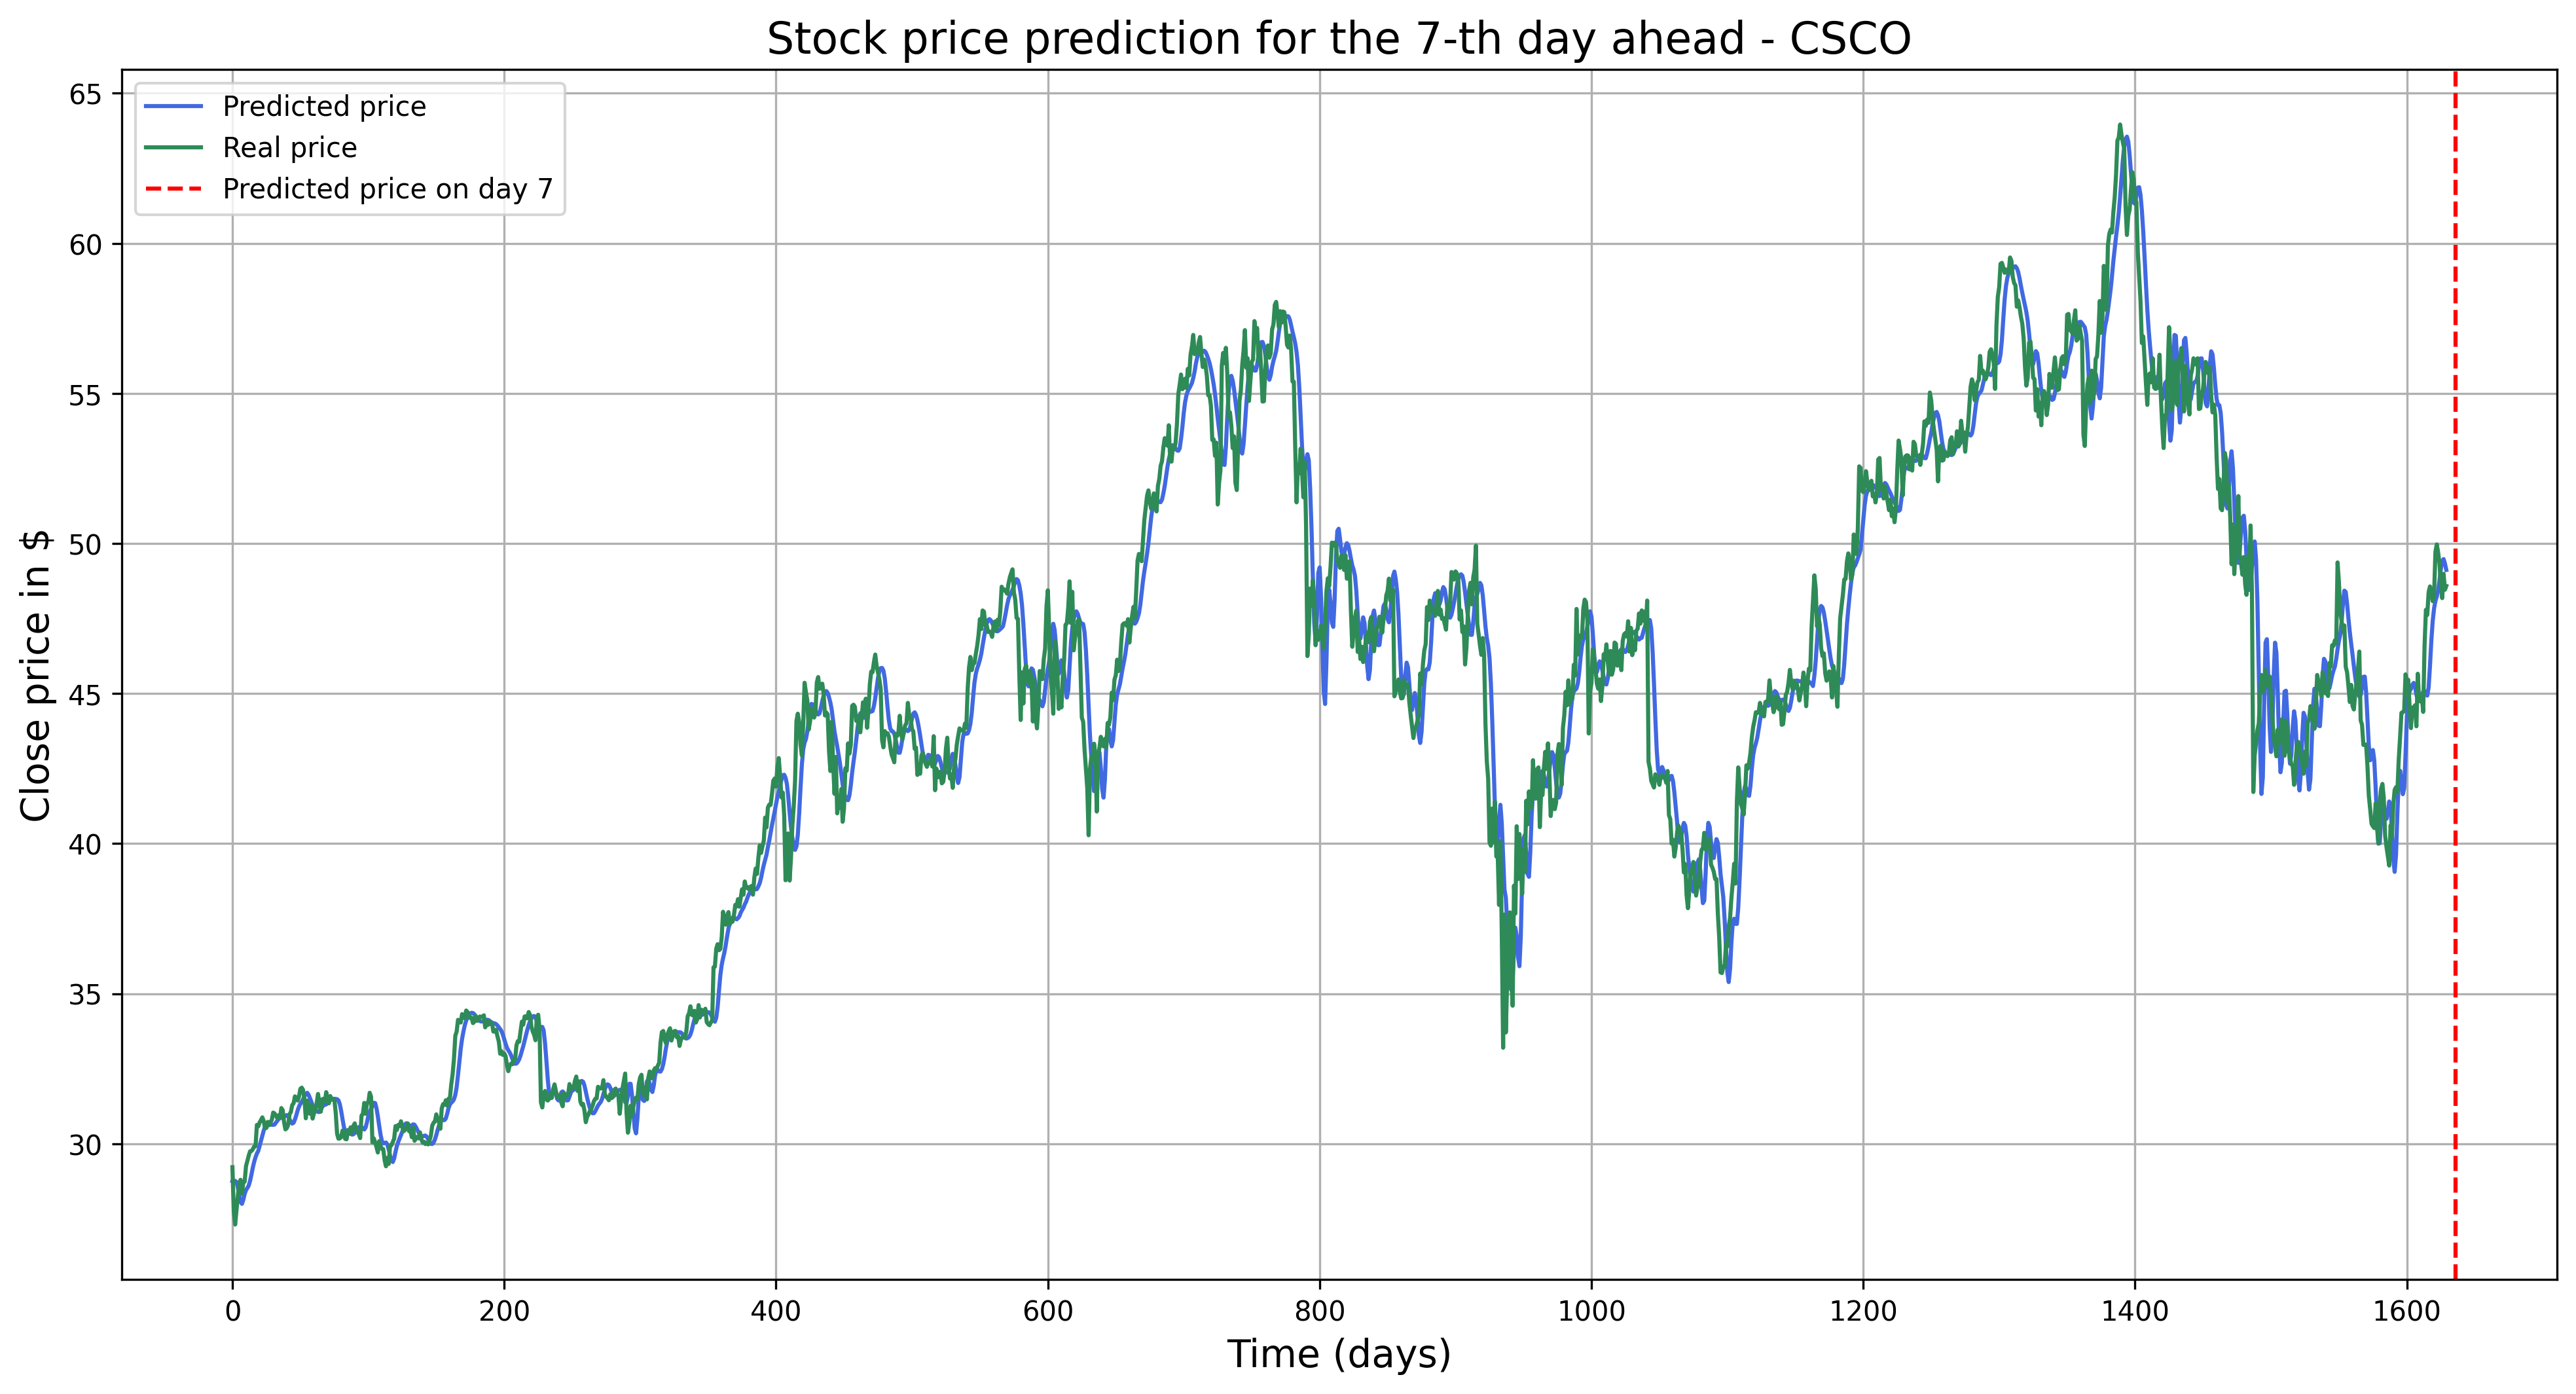

X_train_norm shape:  (6820, 120, 1)
y_train_norm shape:  (6820,)
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 736ms/step - loss: 4.8435 - mse: 4.8435 - val_loss: 0.0957 - val_mse: 0.0957
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step - loss: 0.0894 - mse: 0.0894 - val_loss: 0.0690 - val_mse: 0.0690
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - loss: 0.0609 - mse: 0.0609 - val_loss: 0.0398 - val_mse: 0.0398
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/step - loss: 0.0401 - mse: 0.0401 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step - loss: 0.0328 - mse: 0.0328 - val_loss: 0.0256 - val_mse: 0.0256
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 415ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0210 - val_mse: 0.0210
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - loss: 0.0255 - mse: 0.0255 - val_loss: 0.0201 - val_mse: 0.0201
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step - loss: 0.0229 - mse: 0.0229 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 9

MSE on the test set:  0.018007180126694236
Model saved: saved_models/INTC_model.h5
Metadata saved: model_metadata/INTC_metadata.json
Error generating features for prediction: "None of [Index(['open', 'high', 'low', 'volume'], dtype='object')] are in the [columns]"
Failed to generate prediction features.


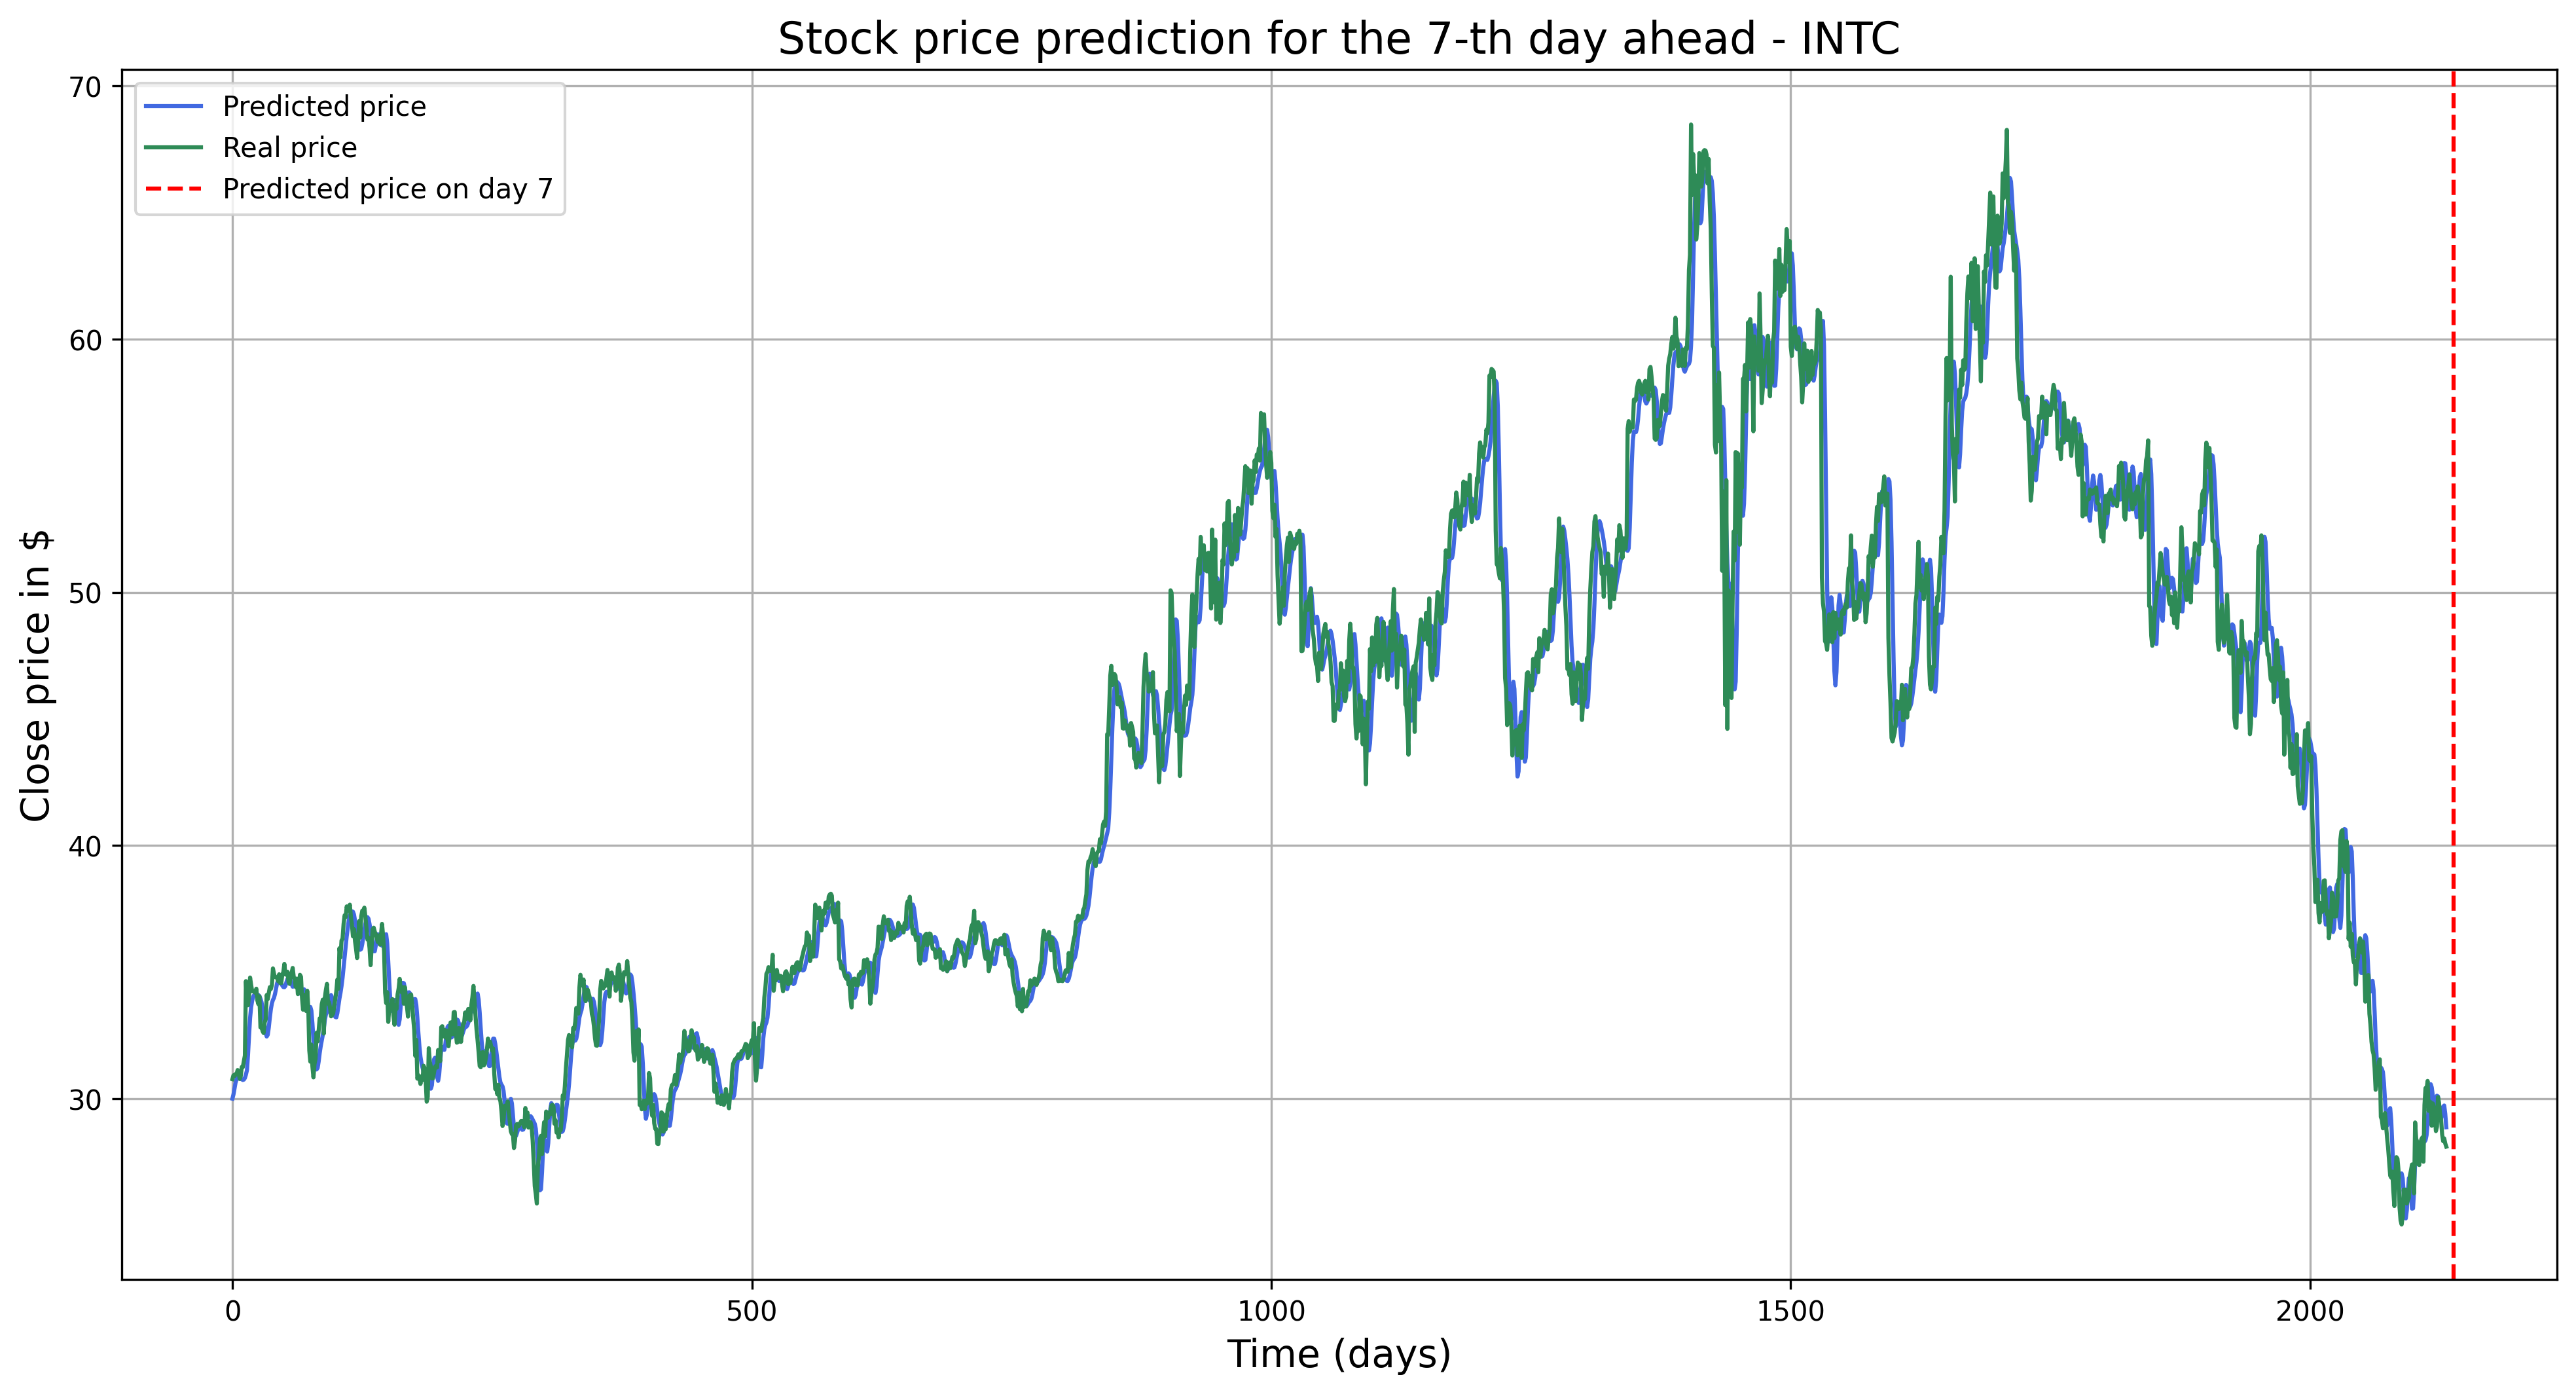

X_train_norm shape:  (5851, 120, 1)
y_train_norm shape:  (5851,)
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 437ms/step - loss: 1.5705 - mse: 1.5705 - val_loss: 0.1582 - val_mse: 0.1582
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 403ms/step - loss: 0.1146 - mse: 0.1146 - val_loss: 0.1013 - val_mse: 0.1013
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step - loss: 0.0780 - mse: 0.0780 - val_loss: 0.0434 - val_mse: 0.0434
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - loss: 0.0482 - mse: 0.0482 - val_loss: 0.0370 - val_mse: 0.0370
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - loss: 0.0381 - mse: 0.0381 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step - loss: 0.0327 - mse: 0.0327 - val_loss: 0.0277 - val_mse: 0.0277
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0256 - val_mse: 0.0256
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - loss: 0.0274 - mse: 0.0274 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 9

MSE on the test set:  0.018676942293907796
Model saved: saved_models/MSFT_model.h5
Metadata saved: model_metadata/MSFT_metadata.json
Error generating features for prediction: "None of [Index(['open', 'high', 'low', 'volume'], dtype='object')] are in the [columns]"
Failed to generate prediction features.


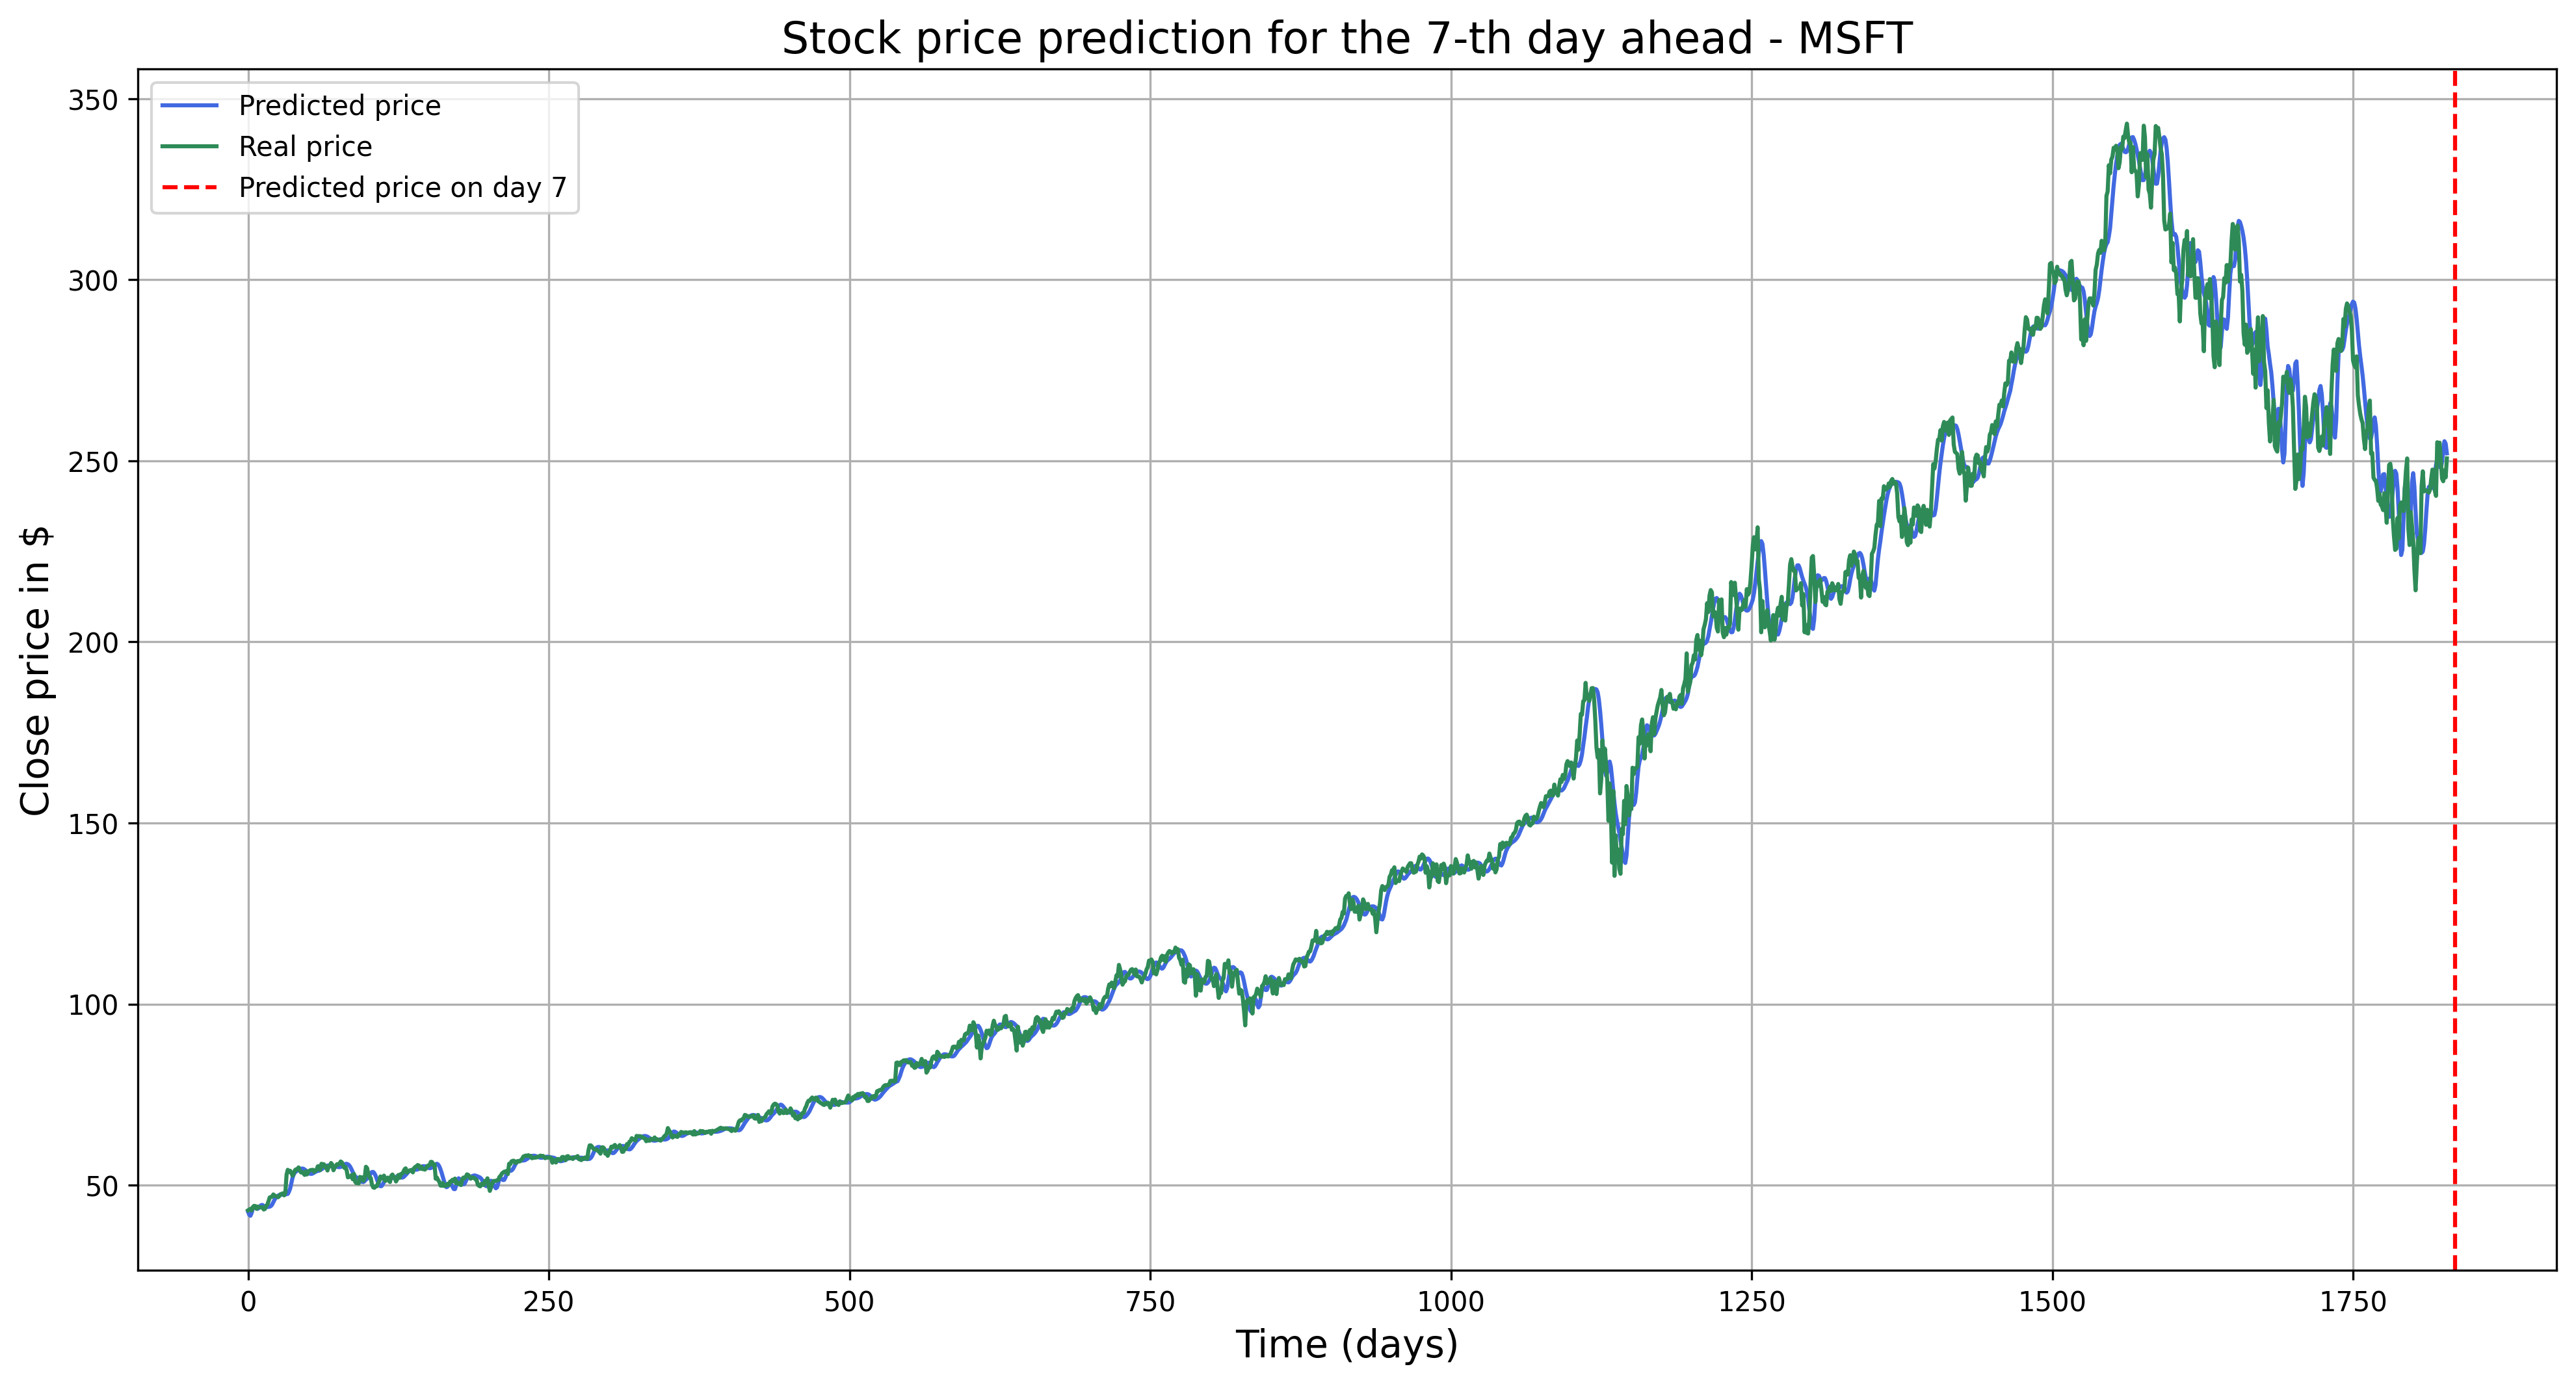

X_train_norm shape:  (3235, 120, 1)
y_train_norm shape:  (3235,)
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 521ms/step - loss: 2.7847 - mse: 2.7847 - val_loss: 0.1026 - val_mse: 0.1026
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 403ms/step - loss: 0.1566 - mse: 0.1566 - val_loss: 0.2639 - val_mse: 0.2639
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - loss: 0.2034 - mse: 0.2034 - val_loss: 0.0887 - val_mse: 0.0887
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - loss: 0.1175 - mse: 0.1175 - val_loss: 0.0659 - val_mse: 0.0659
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - loss: 0.0821 - mse: 0.0821 - val_loss: 0.0857 - val_mse: 0.0857
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step - loss: 0.0832 - mse: 0.0832 - val_loss: 0.0539 - val_mse: 0.0539
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step - loss: 0.0659 - mse: 0.0659 - val_loss: 0.0511 - val_mse: 0.0511
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 374ms/step - loss: 0.0533 - mse: 0.0533 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 9

MSE on the test set:  0.03552293093481301
Model saved: saved_models/NFLX_model.h5
Metadata saved: model_metadata/NFLX_metadata.json
Error generating features for prediction: "None of [Index(['open', 'high', 'low', 'volume'], dtype='object')] are in the [columns]"
Failed to generate prediction features.


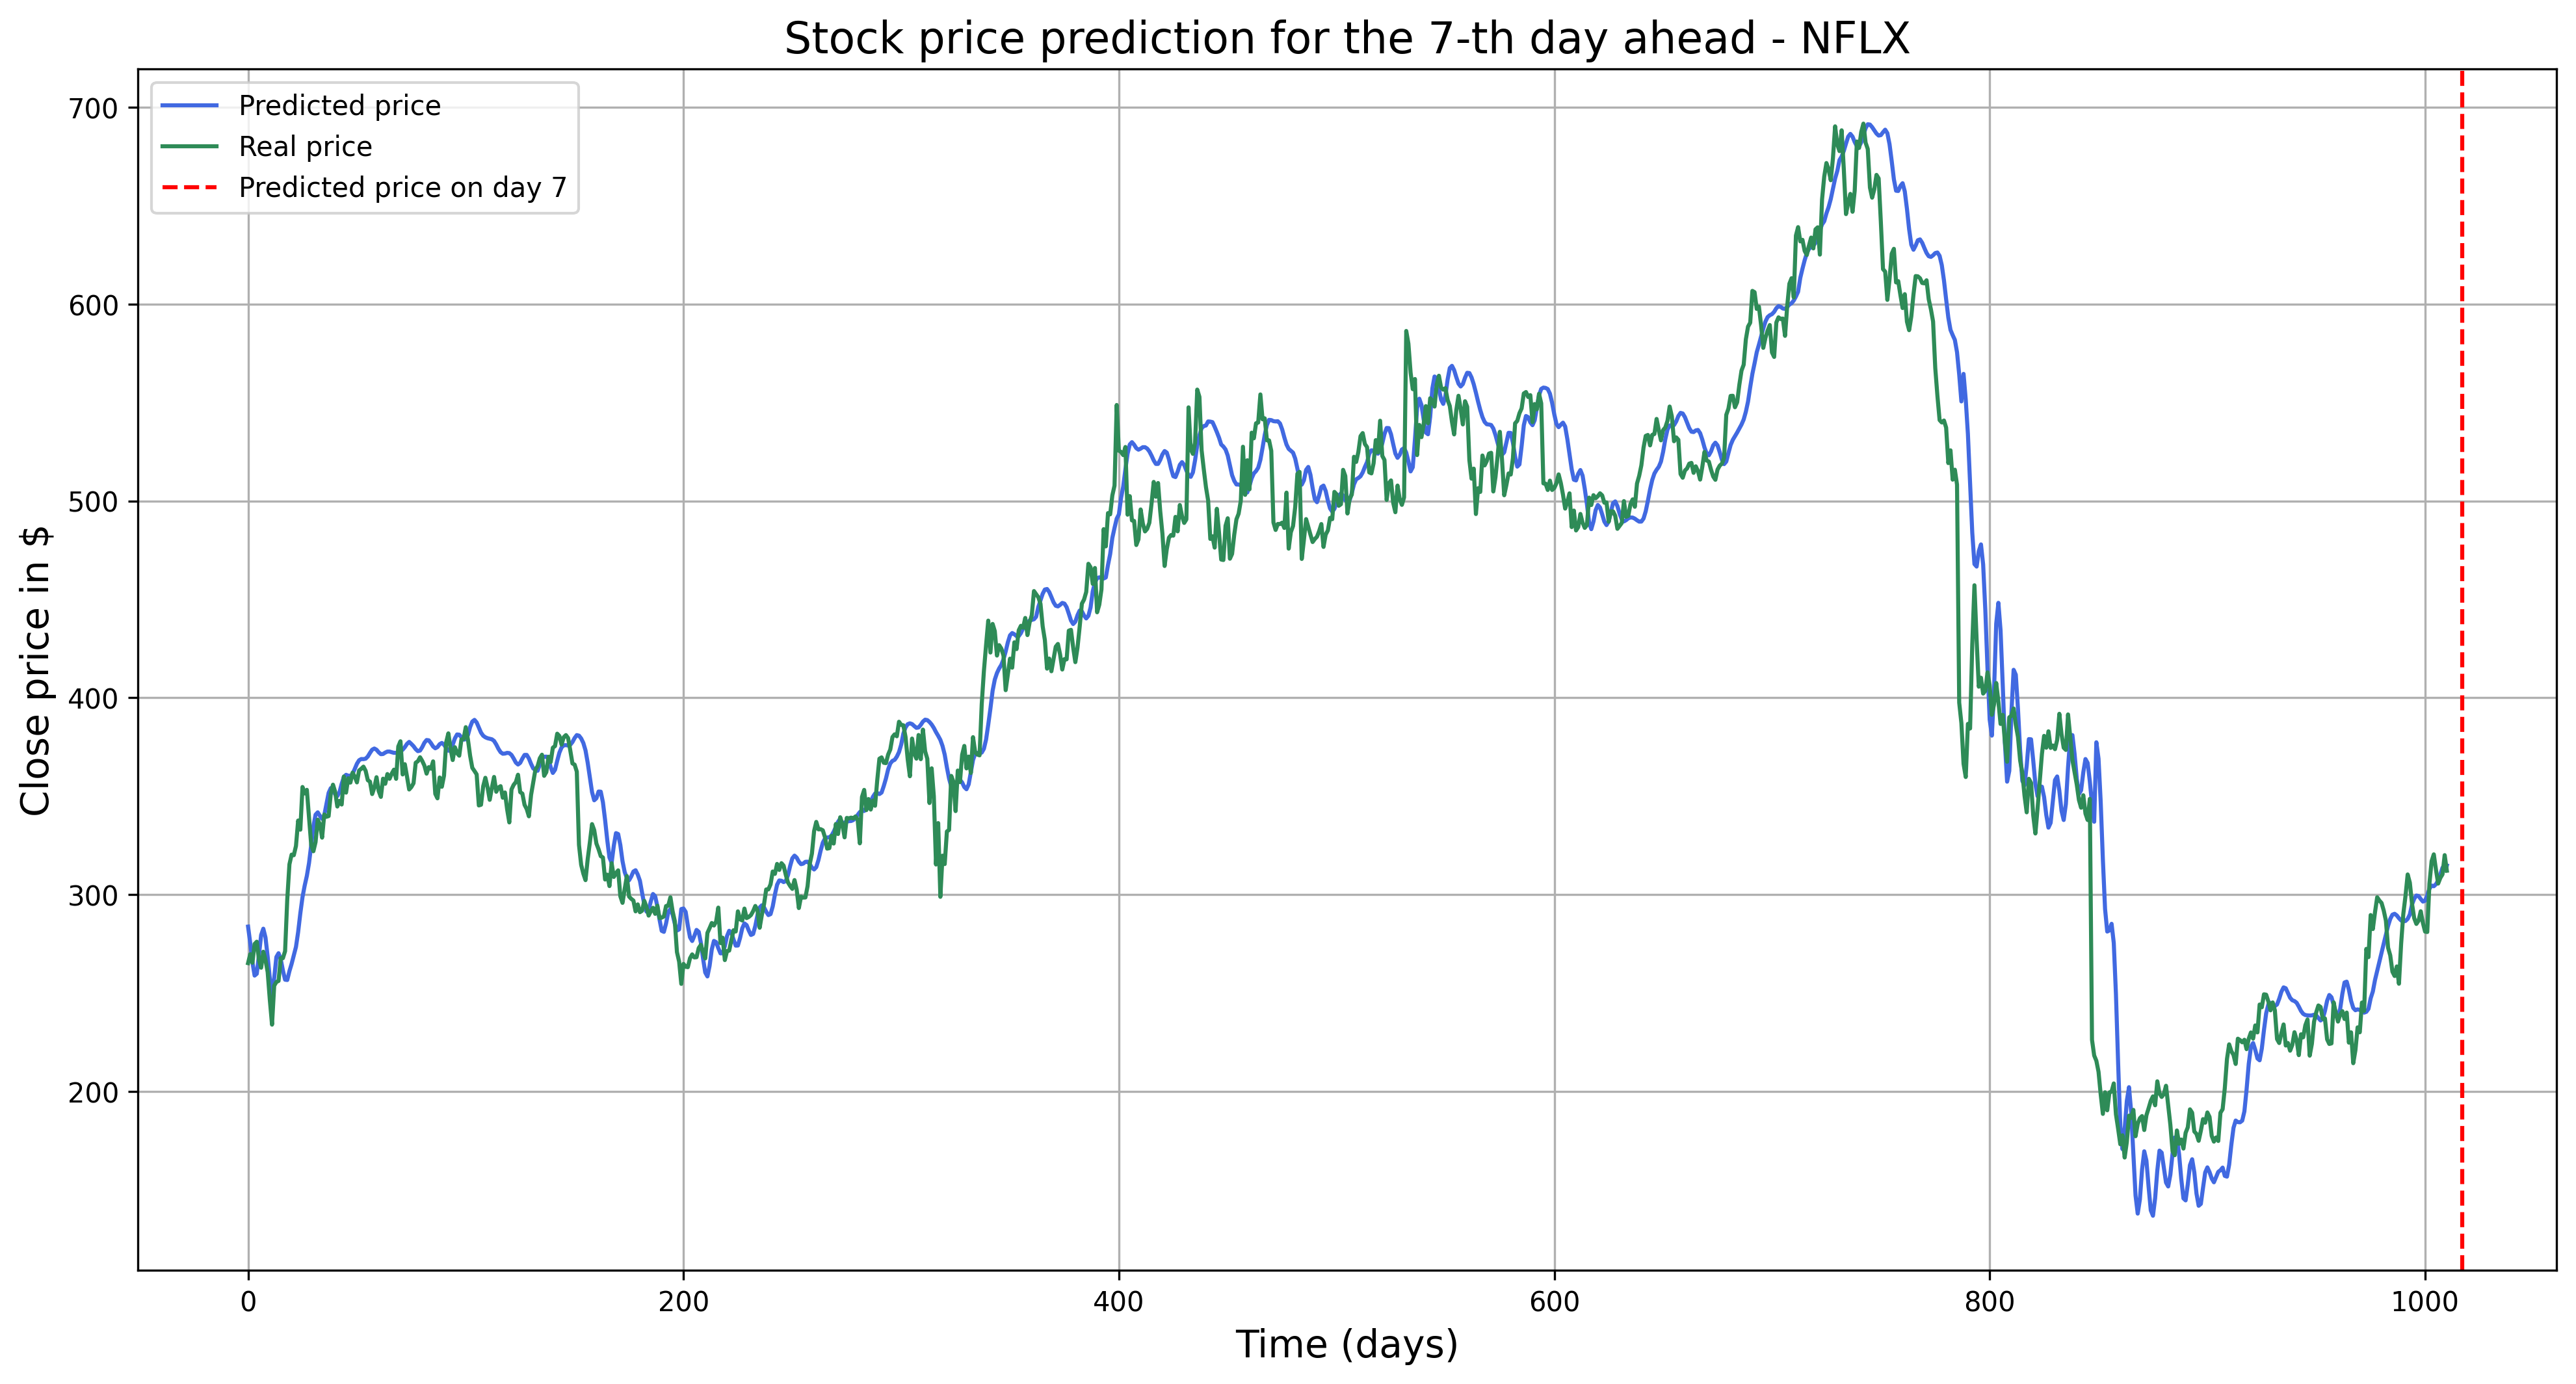

X_train_norm shape:  (3770, 120, 1)
y_train_norm shape:  (3770,)
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 664ms/step - loss: 0.8858 - mse: 0.8858 - val_loss: 0.0822 - val_mse: 0.0822
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - loss: 0.0903 - mse: 0.0903 - val_loss: 0.3010 - val_mse: 0.3010
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 942ms/step - loss: 0.1382 - mse: 0.1382 - val_loss: 0.1344 - val_mse: 0.1344
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0811 - mse: 0.0811 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 930ms/step - loss: 0.0588 - mse: 0.0588 - val_loss: 0.0630 - val_mse: 0.0630
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step - loss: 0.0471 - mse: 0.0471 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 694ms/step - loss: 0.0335 - mse: 0.0335 - val_loss: 0.0355 - val_mse: 0.0355
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0311 - mse: 0.0311 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 9/10
4/

MSE on the test set:  0.02311905488727044
Model saved: saved_models/NVDA_model.h5
Metadata saved: model_metadata/NVDA_metadata.json
Error generating features for prediction: "None of [Index(['open', 'high', 'low', 'volume'], dtype='object')] are in the [columns]"
Failed to generate prediction features.


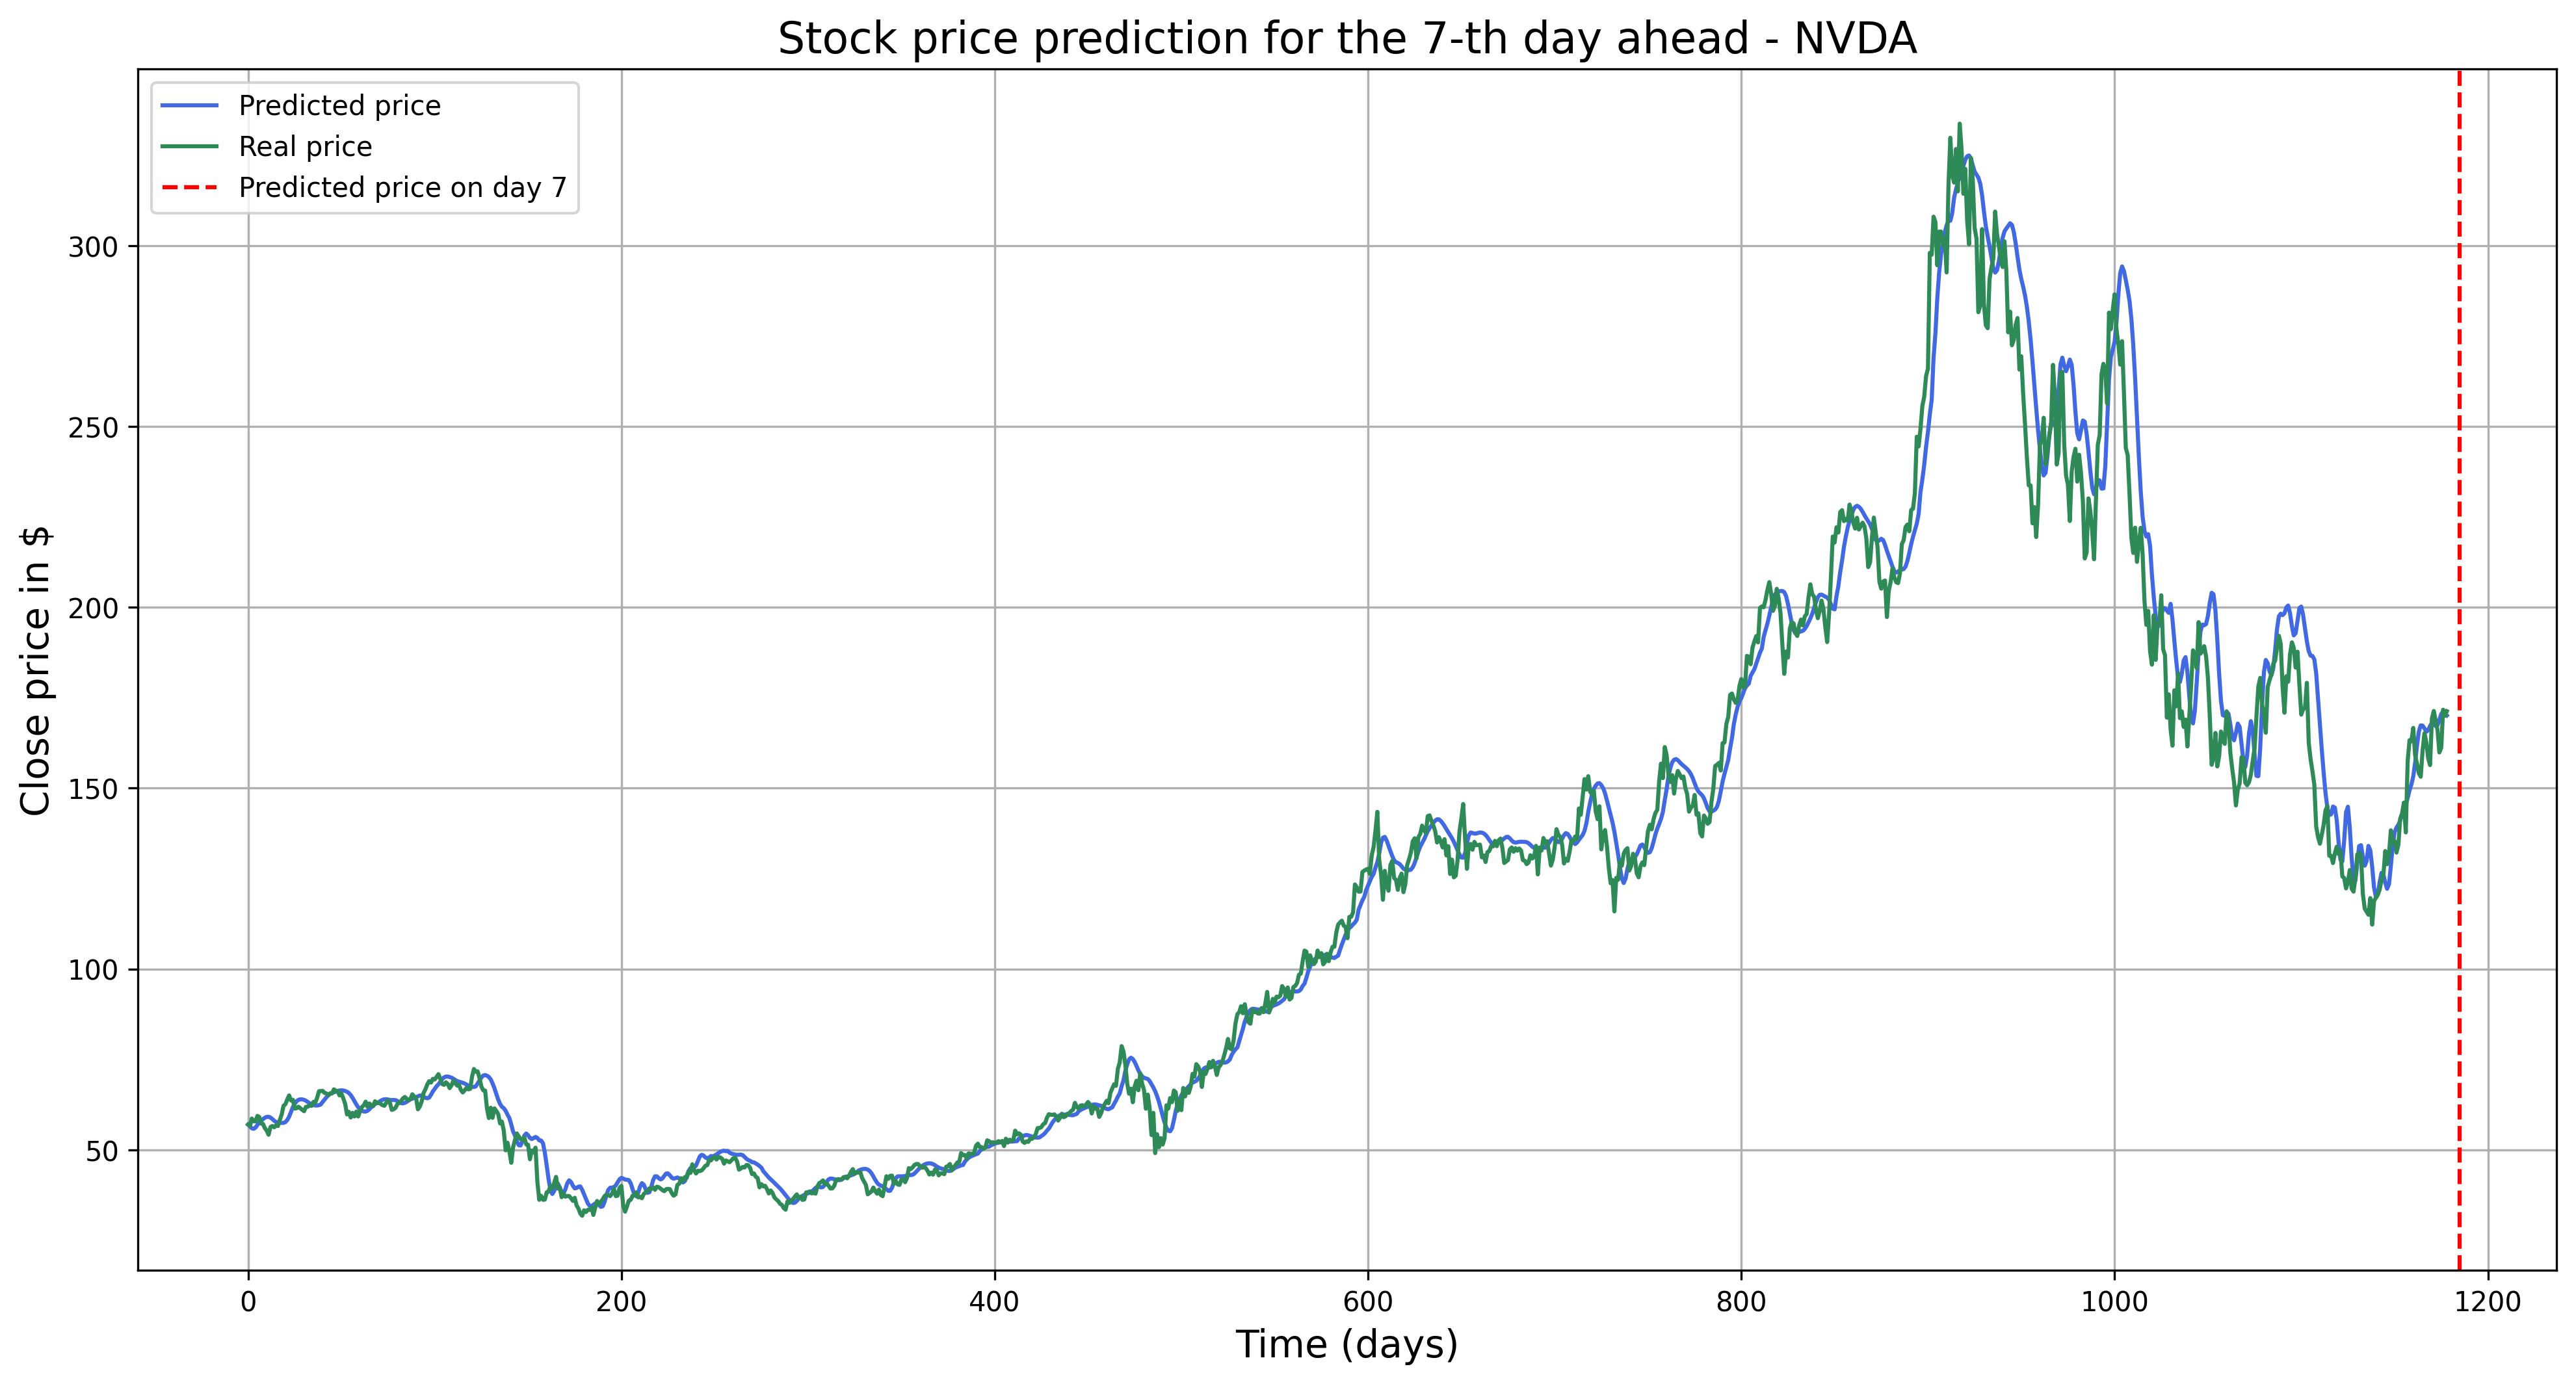

X_train_norm shape:  (4700, 120, 1)
y_train_norm shape:  (4700,)
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 5.4588 - mse: 5.4588 - val_loss: 0.0948 - val_mse: 0.0948
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 682ms/step - loss: 0.0847 - mse: 0.0847 - val_loss: 0.1038 - val_mse: 0.1038
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 880ms/step - loss: 0.0783 - mse: 0.0783 - val_loss: 0.0440 - val_mse: 0.0440
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.0589 - mse: 0.0589 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - loss: 0.0475 - mse: 0.0475 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 698ms/step - loss: 0.0392 - mse: 0.0392 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 716ms/step - loss: 0.0370 - mse: 0.0370 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 565ms/step - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0238 - val_mse: 0.0238
Epoch 9/10


MSE on the test set:  0.022131943391444007
Model saved: saved_models/ORLY_model.h5
Metadata saved: model_metadata/ORLY_metadata.json
Error generating features for prediction: "None of [Index(['open', 'high', 'low', 'volume'], dtype='object')] are in the [columns]"
Failed to generate prediction features.


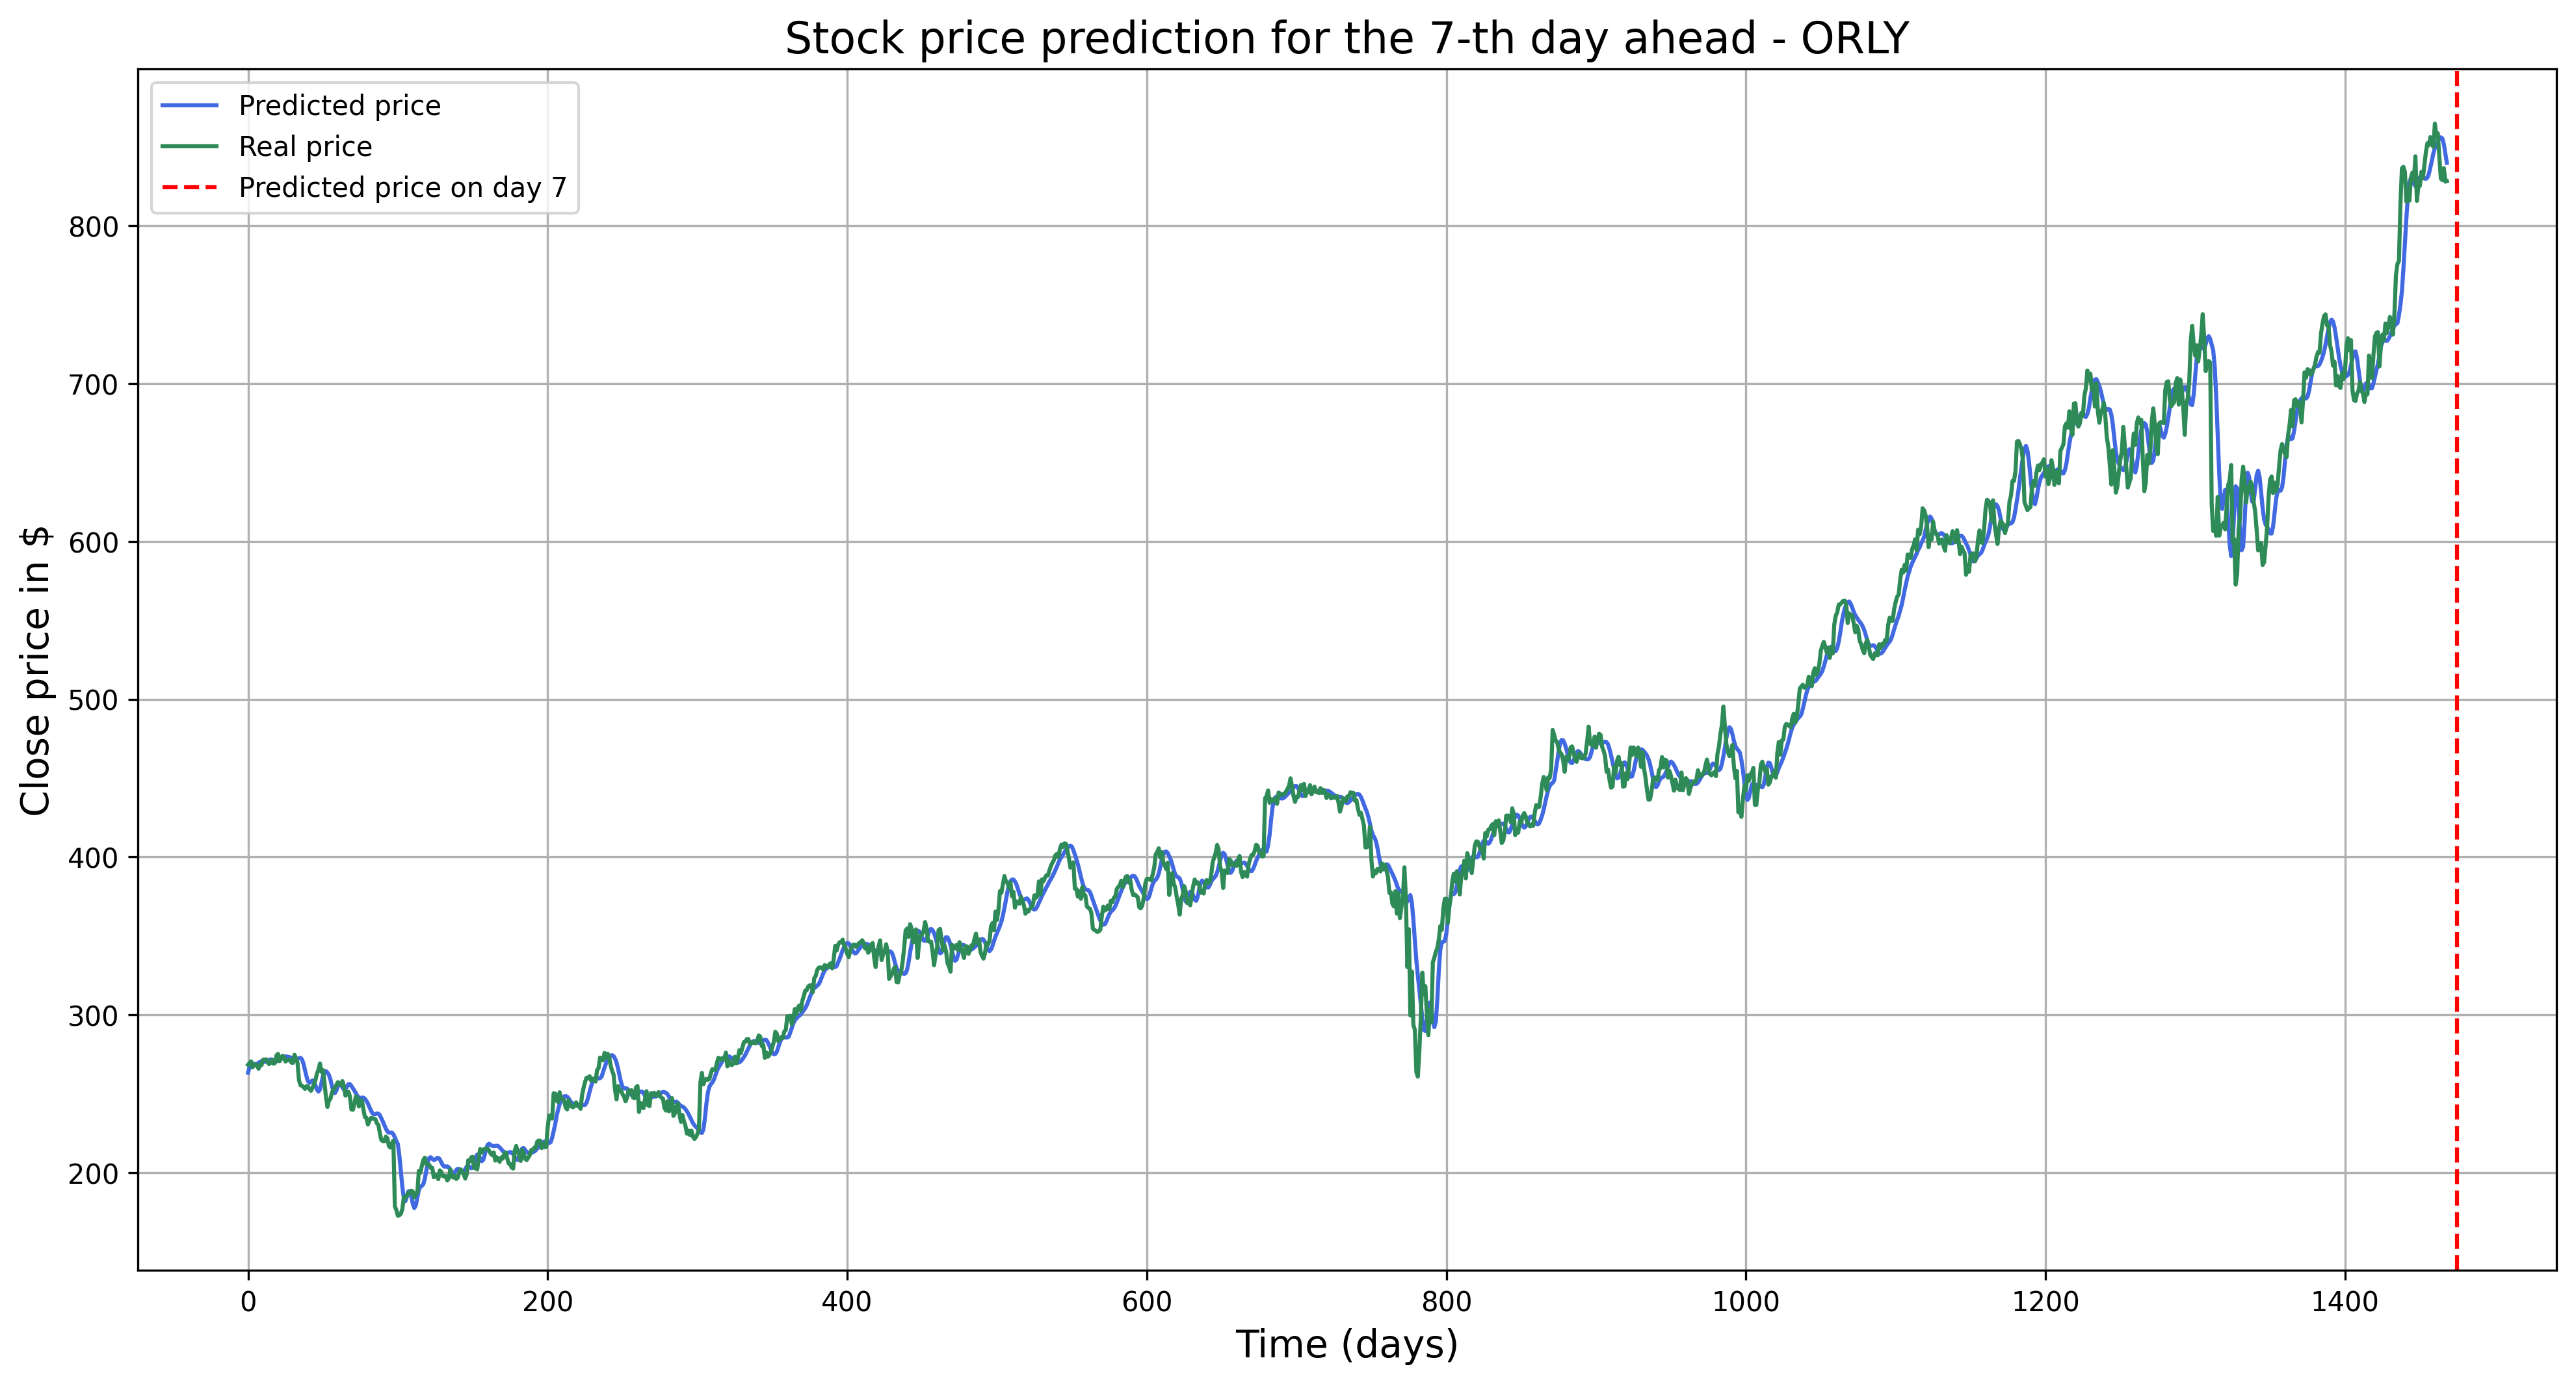

In [15]:
# Preprocessing loop for handling NaN values
for company in nasdaq['company_name'].unique():  # Ensure the loop exists
    company_data = nasdaq[nasdaq.company_name == company].copy()

    # Handle NaN values
    for column in company_data.columns:
        if np.issubdtype(company_data[column].dtype, np.number):
            company_data.loc[:, column] = company_data[column].fillna(company_data[column].mean())
        else:
            company_data.loc[:, column] = company_data[column].fillna(method='ffill')

    # Check for remaining NaN values
    if company_data.isnull().any().any():
        print(f"Warning: NaN values still present in {company}.")
        continue

    # Continue processing for valid data
    print(f"Processing data for {company}.")

# Train the model and save it
for company in nasdaq['company_name'].unique():  # Iterate over unique company names
    window_size = 120
    company_data = nasdaq[nasdaq.company_name == company]
    kth_day(company, company_data, window_size, 7, save_model=True)


In [16]:
# List all saved models
print("\n" + "="*50)
list_saved_models()


Saved models:
  - ASML (MSE: 0.024299, Trained: 2025-06-22)
  - AMZN (MSE: 0.024154, Trained: 2025-06-22)
  - ORLY (MSE: 0.022132, Trained: 2025-06-22)
  - MSFT (MSE: 0.018677, Trained: 2025-06-22)
  - AAPL (MSE: 0.016963, Trained: 2025-06-22)
  - ADBE (MSE: 0.021659, Trained: 2025-06-22)
  - CSCO (MSE: 0.020412, Trained: 2025-06-22)
  - NVDA (MSE: 0.023119, Trained: 2025-06-22)
  - INTC (MSE: 0.018007, Trained: 2025-06-22)
  - NFLX (MSE: 0.035523, Trained: 2025-06-22)
